# Stock Deep Recurrent Q-Network 
This notebook provides an implementation of a Deep Double Recurrent Q-Network which can solve Partially Observable Markov Decision Processes. This notebook applies the technique on time series.

In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import os
import csv
import itertools
%matplotlib inline
import time
from sklearn.preprocessing import MinMaxScaler
from helper import *
from StockEnv import StockEnv
import pandas as pd
from GeometricBrownianMotion import * 
from MCSAmericanOptionPricing import *

seed = 1 #time.time()
random.seed(seed)
print('Seed is:' + str(seed))

Seed is:1


### Variable settings

In [2]:
"""So = 100 #spot_price #110 #90 #100 110 #127.62 #90
strike_price = 100 #130 #100
mu = 10/100 #risk_free_rate #0.001 #5/100
sigma = 0.20 #volatility # the historical vols or implied vols
dividend_rate = 0.0 #0.0163 #dividend yield of 1.63%
num_seeds = 20000"""
risk_free_rate = 5/100
mu = risk_free_rate
sigma = 0.20
num_seeds = 60

In [3]:
save_model_freq = 10000 #5000
Normalization = False #True #False
Window_Normalization = False #True #False
test_data_ratio = 0.6 #0.3 # 0.2

architecture = 0 #3 #0 #1 #2 #3 #4 #5
nbFilters = 32 #16 #1
paddingType = 'same' #'causal' # 'valid'
huber_loss = True #False
dueling_type = 'max' #'naive'
mask_type = 'default' #'maskFirstHalf' # 'maskByWeights' 'default'
apply_dropout = True
batch_size = 64 #16 #32 #128 #60 #20 #4 #How many experience traces to use for each training step.
memory_capacity = 3000 #3000 #1000
learning_rate = 0.0025 #0.00025 #0.01 0.025 0.0025 0.0001
apply_grad_clipping = True
grad_clipping = 5 # Maybe test with bigger values, e.g. 40 or 30
optimizer_type = 'Adam' # 'GradientDescent' 'RMSProp'

Colab = False
scriptDirectory = os.getcwd() #"C:\Code_RL\2019_11_21_shuffled_GBM_version" #"C:\\Code_RL" # os.getcwd()

history_t = 15 #5 #15 #2 #15 ##
option_T = 50 #65 #50 #100 #365 #100 #200 #365 #65 #30 #15 #40 #30 ##
#build_warm_up_state_t = option_T // 3 #option_T // 2
input_size = history_t + 2
is_training = True

In [4]:
"""stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ibm.us.txt', 'ups.us.txt',
              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',
              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',
              'trno.us.txt', 'trk.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt',
              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',
               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',
               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',
               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',
              'mrk.us.txt', 'ba.us.txt', 'pfe.us.txt', 'cmcsa.us.txt',
               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',
               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',
              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',
               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', 'bp.us.txt',
               'pm.us.txt', 'amgn.us.txt', 'abbv.us.txt', 'hon.us.txt']
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(test_data)), test_data, color='r')  """ 

"stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ibm.us.txt', 'ups.us.txt',\n              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',\n              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',\n              'trno.us.txt', 'trk.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt',\n              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',\n               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',\n               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',\n               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',\n              'mrk.us.txt', 'ba.us.txt', 'pfe.us.txt', 'cmcsa.us.txt',\n               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',\n               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',\n              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',\n               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', 'bp.us.txt',\n              

##hpq.us.txtmin date: 1970-01-02max date: 2017-11-10
min value of data: 8.53125, max value of data: 22.20295
train_size: 367
test_size: 549
##aapl.us.txtmin date: 1984-09-07max date: 2017-11-10
min value of data: 68.814, max value of data: 174.825
train_size: 367
test_size: 549
##goog.us.txtmin date: 2014-03-27max date: 2017-11-10
min value of data: 491.77, max value of data: 1035.9850000000001
train_size: 367
test_size: 549
##ibm.us.txtmin date: 1962-01-02max date: 2017-11-10
min value of data: 110.81, max value of data: 176.43
train_size: 367
test_size: 549
##ups.us.txtmin date: 1999-11-10max date: 2017-11-10
min value of data: 83.2025, max value of data: 119.64
train_size: 367
test_size: 549
##jnj.us.txtmin date: 1970-01-02max date: 2017-11-10
min value of data: 83.78399999999999, max value of data: 143.231
train_size: 367
test_size: 549
##msft.us.txtmin date: 1986-03-13max date: 2017-11-10
min value of data: 35.632999999999996, max value of data: 84.905
train_size: 367
test_size: 5

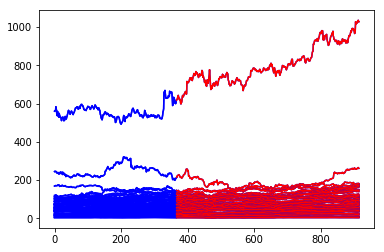

In [5]:
stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ibm.us.txt', 'ups.us.txt',
              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',
              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',
              'trno.us.txt', 'trk.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt',
              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',
               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',
               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',
               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',
              'mrk.us.txt', 'ba.us.txt', 'pfe.us.txt', 'cmcsa.us.txt',
               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',
               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',
              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',
               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', 'bp.us.txt',
               'pm.us.txt', 'amgn.us.txt', 'abbv.us.txt', 'hon.us.txt']
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r')

### Load the game environment

Setting our environment

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 283
num_episodes_per_epoch: 18120
min value of stock: 79.153, max value of stock: 101.875


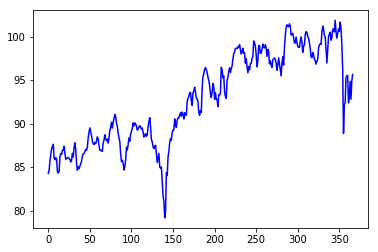

In [6]:
############################################################################
#env = StockEnv(train_data, risk_free_rate, history_t=history_t, option_T=option_T)
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
build_warm_up_state_t = env.get_build_warm_up_state()
trace_length = option_T - build_warm_up_state_t
num_samples = batch_size*trace_length
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

In [7]:
kappa=1.0
num_tau_samples=64
num_tau_prime_samples=64
num_quantile_samples=32
quantile_embedding_dim=64

# to remove and keep num_quantile_samples only
#num_quantiles = num_quantile_samples
double_dqn = True
num_actions = 2

### Implementing the network itself

In [8]:
class Qnetwork():
    def __init__(self,myScope):
        
        self.scalarInput = tf.placeholder(shape=[None,input_size],dtype=tf.float32, name='scalarInput')
        
        # depending on the chosen architecture, data is processed through differents layers
        
        # convolutions are used in all type, except architecture 0 which only uses LSTM
        if architecture != 0:
          self.InputConvIn = tf.reshape(self.scalarInput,shape=[-1,input_size,1], name='InputConvIn')
          self.conv1 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.InputConvIn)
        
        if architecture == 0: # LSTM only
          self.scalarInputFlattened = tf.keras.layers.Flatten()(self.scalarInput)
        elif architecture == 1: # only one convolution
          self.conv1flattened = tf.reshape(self.conv1,shape=[-1,self.conv1.shape[1]*self.conv1.shape[2]], name='conv1flattened')
        elif architecture == 2: # only one convolution followed by max pooling
          self.maxPooling1D = tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.maxPooling1Dflattened = tf.reshape(self.maxPooling1D,shape=[-1,self.maxPooling1D.shape[1]*self.maxPooling1D.shape[2]], name='maxPooling1Dflattened')
        elif architecture == 3: # only one convolution followed by average pooling
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.AveragePooling1Dflattened = tf.reshape(self.AveragePooling1D,shape=[-1,self.AveragePooling1D.shape[1]*self.AveragePooling1D.shape[2]], name='AveragePooling1Dflattened')  
        elif architecture == 4: #VGG (one block of 2 convolutions followed by avg pooling)
          self.conv2 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.conv1)
          self.AveragePooling1D4 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv2)
          self.AveragePooling1Dflattened4 = tf.reshape(self.AveragePooling1D4,shape=[-1,self.AveragePooling1D4.shape[1]*self.AveragePooling1D4.shape[2]], name='AveragePooling1Dflattened4')
        elif architecture == 5: #Lenet (conv, avg pooling, conv, avg pooling)
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.conv2 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,#5, #3, #maybe unstable calculations because of 5 instead of 3
                                               strides=1,
                                               padding= paddingType, #'same',
                                               #activation=tf.keras.activations.hard_sigmoid
                                               #activation=tf.keras.activations.sigmoid
                                               #activation=tf.keras.activations.tanh
                                               activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.AveragePooling1D5 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv2)
          self.AveragePooling1Dflattened5 = tf.reshape(self.AveragePooling1D5,shape=[-1,self.AveragePooling1D5.shape[1]*self.AveragePooling1D5.shape[2]], name='AveragePooling1Dflattened5')
        elif architecture == 6: #Googlenet (Inception net: combine (conv&avgPooling) + conv1 + conv3 + conv5)
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.conv11 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=1,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.conv3 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=3,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.conv5 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=5,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.filterconcatenation = tf.concat([self.conv11, self.conv3, self.conv5, self.AveragePooling1D], 2, name = 'filterconcatenation')
          self.filterconcatenationflattened = tf.reshape(self.filterconcatenation,shape=[-1,self.filterconcatenation.shape[1]*self.filterconcatenation.shape[2]], name='filterconcatenationflattened')
        
        self.trainLength = tf.placeholder(dtype=tf.int32, name='trainLength')
        self.batch_size = tf.placeholder(dtype=tf.int32,shape=[], name='batch_size')
 
        #We take the output from the final convolutional layer and send it to a recurrent layer.
        #The input must be reshaped into [batch x trace x units] for rnn processing, 
        #and then returned to [batch x units] when sent through the upper levles.
        if architecture == 0:
          self.convFlat = tf.reshape(self.scalarInputFlattened,[self.batch_size,self.trainLength,input_size])
        elif architecture == 1:
          self.convFlat = tf.reshape(self.conv1flattened,[self.batch_size,self.trainLength,self.conv1flattened.shape[1]])
        elif architecture == 2:
          self.convFlat = tf.reshape(self.maxPooling1Dflattened,[self.batch_size,self.trainLength,self.maxPooling1Dflattened.shape[1]])
        elif architecture == 3:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened.shape[1]])
        elif architecture == 4:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened4,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened4.shape[1]])
        elif architecture == 5:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened5,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened5.shape[1]])
        elif architecture == 6:
          self.convFlat = tf.reshape(self.filterconcatenationflattened,[self.batch_size,self.trainLength,self.filterconcatenationflattened.shape[1]])
        
        # use cudnn-based cells to leverage Nvidia GPUs
        single_cell = lambda: tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(h_size)
    
        # NOTE: Even if there's only one layer, the cell needs to be wrapped in MultiRNNCell.
        lstm_cells = [single_cell() for _ in range(num_layers)]
        if is_training and apply_dropout and dropout < 1:
            lstm_cells = [tf.contrib.rnn.DropoutWrapper(
                lstm, input_keep_prob=1.0, output_keep_prob=1.0 - dropout, state_keep_prob=1.0 - dropout
            ) for lstm in lstm_cells]
        multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells, state_is_tuple=True)

        self.state_in = tf.placeholder(tf.float32, [num_layers, 2, None, h_size], name='state_in')
        state_per_layer_list = tf.unstack(self.state_in, axis=0)
        rnn_tuple_state = tuple(
            [tf.contrib.rnn.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
             for idx in range(num_layers)]
        )
        
        # calculate the real length of each episode (since remaining states are filled with 0s after selling)
        # This is required by RNN 
        self.seq_len = length(self.convFlat)
        
        self.rnn,self.rnn_state = tf.nn.dynamic_rnn(\
                cell=multi_cell,
                inputs=self.convFlat,                                    
                dtype=tf.float32,
                initial_state=rnn_tuple_state, 
                sequence_length=self.seq_len,
                scope=myScope+'_lstm')
        

        self.rnn = tf.reshape(self.rnn,shape=[-1,h_size])
        ############################### IQN code
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32, name='actions')
        self.actions_onehot = tf.one_hot(self.actions,2,dtype=tf.float32)
        self.target_quantile_values = tf.placeholder(shape=[None, num_tau_prime_samples, 1],dtype=tf.float32, name='target_quantile_values')
        
        weights_initializer = slim.variance_scaling_initializer(factor=1.0 / np.sqrt(3.0), mode='FAN_IN', uniform=True)
        
        self.num_quantiles = tf.placeholder(dtype=tf.int32, name='num_quantiles')
        
        self.state_net_size = self.rnn.get_shape().as_list()[-1]
        state_net_tiled = tf.tile(self.rnn, [self.num_quantiles, 1])

        self.quantiles_shape = tf.placeholder(dtype=tf.int32, name='quantiles_shape')

        self.quantiles = tf.random_uniform([self.quantiles_shape, 1], minval=0, maxval=1, dtype=tf.float32)

        quantile_net = tf.tile(self.quantiles, [1, quantile_embedding_dim])
        pi = tf.constant(math.pi)
        quantile_net = tf.cast(tf.range(1, quantile_embedding_dim + 1, 1), tf.float32) * pi * quantile_net
        quantile_net = tf.cos(quantile_net)
        quantile_net = slim.fully_connected(quantile_net, self.state_net_size,
                                              weights_initializer=weights_initializer)
        # Hadamard product.
        net = tf.multiply(state_net_tiled, quantile_net)

        net = slim.fully_connected(net, 512, weights_initializer=weights_initializer)
        self.quantile_values = slim.fully_connected(
              net,
              num_actions,
              activation_fn=None,
              weights_initializer=weights_initializer)
        
        self._q_values = tf.reduce_mean(self.quantile_values, axis=0)
        self.predict = tf.argmax(self._q_values, axis=0)

        # Shape of indices: (num_tau_samples x batch_size) x 1.
        # Expand dimension by one so that it can be used to index into all the
        # quantiles when using the tf.gather_nd function (see below).
        indices = tf.range(num_tau_samples * num_samples)[:, None]

        # Expand the dimension by one so that it can be used to index into all the
        # quantiles when using the tf.gather_nd function (see below).
        reshaped_actions = self.actions[:, None]
        reshaped_actions = tf.tile(reshaped_actions, [num_tau_samples, 1])
        # Shape of reshaped_actions: (num_tau_samples x batch_size) x 2.
        reshaped_actions = tf.concat([indices, reshaped_actions], axis=1)

        chosen_action_quantile_values = tf.gather_nd(
            self.quantile_values, reshaped_actions)
        # Reshape to self.num_tau_samples x batch_size x 1 since this is the manner
        # in which the quantile values are tiled.
        chosen_action_quantile_values = tf.reshape(chosen_action_quantile_values,\
                                                   [num_tau_samples,num_samples, 1])
        # Transpose dimensions so that the dimensionality is batch_size x
        # self.num_tau_samples x 1 to prepare for computation of
        # Bellman errors.
        # Final shape of chosen_action_quantile_values:
        # batch_size x num_tau_samples x 1.
        chosen_action_quantile_values = tf.transpose(chosen_action_quantile_values, [1, 0, 2])

        # Shape of bellman_erors and huber_loss:
        # batch_size x num_tau_prime_samples x num_tau_samples x 1.
        bellman_errors = self.target_quantile_values[
            :, :, None, :] - chosen_action_quantile_values[:, None, :, :]
        # The huber loss (see Section 2.3 of the paper) is defined via two cases:
        # case_one: |bellman_errors| <= kappa
        # case_two: |bellman_errors| > kappa
        huber_loss_case_one = tf.to_float(
            tf.abs(bellman_errors) <= kappa) * 0.5 * bellman_errors ** 2
        huber_loss_case_two = tf.to_float(
            tf.abs(bellman_errors) > kappa) * kappa * (
                tf.abs(bellman_errors) - 0.5 * kappa)
        huber_loss = huber_loss_case_one + huber_loss_case_two

        # Reshape replay_quantiles to batch_size x num_tau_samples x 1
        replay_quantiles = tf.reshape(self.quantiles, [num_tau_samples, num_samples, 1])
        replay_quantiles = tf.transpose(replay_quantiles, [1, 0, 2])

        # Tile by num_tau_prime_samples along a new dimension. Shape is now
        # batch_size x num_tau_prime_samples x num_tau_samples x 1.
        # These quantiles will be used for computation of the quantile huber loss
        # below (see section 2.3 of the paper).
        replay_quantiles = tf.to_float(tf.tile(replay_quantiles[:, None, :, :], [1, num_tau_prime_samples, 1, 1]))
        # Shape: batch_size x num_tau_prime_samples x num_tau_samples x 1.
        quantile_huber_loss = (tf.abs(replay_quantiles - tf.stop_gradient(tf.to_float(bellman_errors < 0))) * huber_loss) / kappa
        # Sum over current quantile value (num_tau_samples) dimension,
        # average over target quantile value (num_tau_prime_samples) dimension.
        # Shape: batch_size x num_tau_prime_samples x 1.
        loss = tf.reduce_sum(quantile_huber_loss, axis=2)
        # Shape: batch_size x 1.
        loss = tf.reduce_mean(loss, axis=1)

        # divide by the real length of episodes instead of averaging which is incorrect
        self.loss = tf.cast(tf.reduce_sum(loss), tf.float64) / tf.cast(tf.reduce_sum(self.seq_len), tf.float64)
        
        #self.check_ops = tf.debugging.check_numerics(self.loss, "self.loss contain Nan or Inf", name="self.check_ops")
        
        
        if optimizer_type == 'Adam':
            optimizer = tf.train.AdamOptimizer(learning_rate)
        elif optimizer_type == 'GradientDescent':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        elif optimizer_type == 'RMSProp':
            optimizer = tf.train.RMSPropOptimizer(learning_rate)
        
        if apply_grad_clipping:
            # calculate gradients and clip them to handle outliers
            tvars = tf.trainable_variables()
            grads, _ = tf.clip_by_global_norm(tf.gradients(self.loss, tvars), grad_clipping)
            self.updateModel = optimizer.apply_gradients(
                    zip(grads, tvars),
                    # global_step=tf.contrib.framework.get_or_create_global_step(),
                    name="updateModel")
        else:
            self.updateModel = optimizer.minimize(self.loss, name="updateModel")
            
    def _build_train_op(self):
        """Builds a training op.
        Returns:
          train_op: An op performing one step of training from replay data.
        """
        # Reshape to self.num_tau_prime_samples x batch_size x 1 since this is
        # the manner in which the target_quantile_values are tiled.
        self.target_quantile_values2 = tf.reshape(self.target_quantile_values,
                                            [num_tau_prime_samples,
                                             num_samples, 1])
        # Transpose dimensions so that the dimensionality is batch_size x
        # self.num_tau_prime_samples x 1 to prepare for computation of
        # Bellman errors.
        # Final shape of target_quantile_values:
        # batch_size x num_tau_prime_samples x 1.
        self.target_quantile_values = tf.transpose(self.target_quantile_values2, [1, 0, 2])

        # Shape of indices: (num_tau_samples x batch_size) x 1.
        # Expand dimension by one so that it can be used to index into all the
        # quantiles when using the tf.gather_nd function (see below).
        indices = tf.range(num_tau_samples * num_samples)[:, None]

        # Expand the dimension by one so that it can be used to index into all the
        # quantiles when using the tf.gather_nd function (see below).
        reshaped_actions = self.actions[:, None]
        reshaped_actions = tf.tile(reshaped_actions, [num_tau_samples, 1])
        # Shape of reshaped_actions: (num_tau_samples x batch_size) x 2.
        reshaped_actions = tf.concat([indices, reshaped_actions], axis=1)

        chosen_action_quantile_values = tf.gather_nd(
            self.quantile_values, reshaped_actions)
        # Reshape to self.num_tau_samples x batch_size x 1 since this is the manner
        # in which the quantile values are tiled.
        chosen_action_quantile_values = tf.reshape(chosen_action_quantile_values,
                                                   [num_tau_samples,
                                                    num_samples, 1])
        # Transpose dimensions so that the dimensionality is batch_size x
        # self.num_tau_samples x 1 to prepare for computation of
        # Bellman errors.
        # Final shape of chosen_action_quantile_values:
        # batch_size x num_tau_samples x 1.
        chosen_action_quantile_values = tf.transpose(
            chosen_action_quantile_values, [1, 0, 2])

        # Shape of bellman_erors and huber_loss:
        # batch_size x num_tau_prime_samples x num_tau_samples x 1.
        bellman_errors = self.target_quantile_values[
            :, :, None, :] - chosen_action_quantile_values[:, None, :, :]
        # The huber loss (see Section 2.3 of the paper) is defined via two cases:
        # case_one: |bellman_errors| <= kappa
        # case_two: |bellman_errors| > kappa
        huber_loss_case_one = tf.to_float(
            tf.abs(bellman_errors) <= kappa) * 0.5 * bellman_errors ** 2
        huber_loss_case_two = tf.to_float(
            tf.abs(bellman_errors) > kappa) * kappa * (
                tf.abs(bellman_errors) - 0.5 * kappa)
        huber_loss = huber_loss_case_one + huber_loss_case_two

        # Reshape replay_quantiles to batch_size x num_tau_samples x 1
        replay_quantiles = tf.reshape(
            self.quantiles, [num_tau_samples, num_samples, 1])
        replay_quantiles = tf.transpose(replay_quantiles, [1, 0, 2])

        # Tile by num_tau_prime_samples along a new dimension. Shape is now
        # batch_size x num_tau_prime_samples x num_tau_samples x 1.
        # These quantiles will be used for computation of the quantile huber loss
        # below (see section 2.3 of the paper).
        replay_quantiles = tf.to_float(tf.tile(
            replay_quantiles[:, None, :, :], [1, num_tau_prime_samples, 1, 1]))
        # Shape: batch_size x num_tau_prime_samples x num_tau_samples x 1.
        quantile_huber_loss = (tf.abs(replay_quantiles - tf.stop_gradient(
            tf.to_float(bellman_errors < 0))) * huber_loss) / kappa
        # Sum over current quantile value (num_tau_samples) dimension,
        # average over target quantile value (num_tau_prime_samples) dimension.
        # Shape: batch_size x num_tau_prime_samples x 1.
        loss = tf.reduce_sum(quantile_huber_loss, axis=2)
        # Shape: batch_size x 1.
        loss = tf.reduce_mean(loss, axis=1)

        # divide by the real length of episodes instead of averaging which is incorrect
        loss = tf.cast(tf.reduce_sum(loss), tf.float64) / tf.cast(tf.reduce_sum(self.seq_len), tf.float64)


        return loss
        

In [9]:
def _build_target_quantile_values_op(_replay_next_qt_argmax, _replay_net_target_quantile_values, 
                                     terminals, rewards):
    """Build an op used as a target for return values at given quantiles.
    Returns:
      An op calculating the target quantile return.
    """
    num_samples = batch_size*trace_length
    # Shape of rewards: (num_tau_prime_samples x batch_size) x 1.
    rewards = rewards[:, None]
    rewards = np.tile(rewards, [num_tau_prime_samples, 1])

    is_terminal_multiplier = 1. - terminals.astype(np.float32) #tf.to_float(terminals)
    # Incorporate terminal state to discount factor.
    # size of gamma_with_terminal: (num_tau_prime_samples x batch_size) x 1.
    gamma_with_terminal = gamma * is_terminal_multiplier
    gamma_with_terminal = np.tile(gamma_with_terminal[:, None],
                                  [num_tau_prime_samples, 1])

    # Get the indices of the maximium Q-value across the action dimension.
    # Shape of replay_next_qt_argmax: (num_tau_prime_samples x batch_size) x 1.

    replay_next_qt_argmax = np.tile(
        _replay_next_qt_argmax[:, None], [num_tau_prime_samples, 1])

    batch_indices = np.arange(num_tau_prime_samples * num_samples)[:, None].astype(np.int64)
    batch_indices = batch_indices * 2
    batch_indexed_target_values = batch_indices + replay_next_qt_argmax

    target_quantile_values = np.squeeze(np.take(_replay_net_target_quantile_values, 
                                                batch_indexed_target_values))[:, None]

    result = rewards + gamma_with_terminal * target_quantile_values

    return result

### Experience Replay

These classes allow us to store experies and sample then randomly to train the network.
Episode buffer stores experiences for each individal episode.
Experience buffer stores entire episodes of experience, and sample() allows us to get training batches needed from the network.

In [10]:
class experience_buffer():
    def __init__(self, buffer_size = memory_capacity, build_warm_up_state_t=build_warm_up_state_t):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
    
    def sample(self,batch_size):
        sampled_episodes = random.sample(self.buffer,batch_size)
        #sampled_episodes = np.array(sampled_episodes)
        sampled_episodes = self.processEpisodes(sampled_episodes)
        return np.reshape(sampled_episodes,[-1,5])
    
    def processEpisodes(self,sampled_episodes):
        sampledTraces = []
        for episode in sampled_episodes:
            sampledTraces.append(episode[build_warm_up_state_t:])
        sampledTraces = np.array(sampledTraces)
        return sampledTraces

### Training the network

In [11]:
#Setting the training parameters
num_layers = 3 # Number of layer of LSTM
h_size = 512 #256 #512 #128 #512 #256 #512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
keep_prob = 0.8
dropout = 1 - keep_prob  # dropout amount
update_freq = 5 #30 #10 #5 #How often to perform a training step.
update_online_freq = 5 #10 #5 #3 #5
update_target_freq = 100 #300 #30
#gamma = discount_factor #.99 #.95 #1 #Discount factor on the target Q-values
gamma = env.get_discount_factor(1) # discount for 1 day
startE = 1 #0.1 #1 #Starting chance of random action
endE = 0.1 #0.01 #0.1 #Final chance of random action
num_epochs = 5
num_episodes = env.get_total_num_episodes_per_epoch()*num_epochs #30 #50000 #20000 #100000 #20000 #3000 #20000 #30000 #10000 #4000 #100000 #40000
pre_train_episodes = int(memory_capacity * 0.1) # 0.25 300 #300 #200 #600 #200
annealing_episodes = int(num_episodes * 0.3) #4*memory_capacity #0.7*memory_capacity #400 #memory_capacity #400
pre_exploitation_episodes = int(num_episodes * 0.6)
annealing_exploitation_episodes = int(num_episodes * 0.25)
exploitationE =  0.01 #0.008 #0.02
load_model = False #Whether to load a saved model.
path = os.path.join(scriptDirectory, 'savedModel') #The path to save our model to.
max_epLength = option_T #env.get_max_episode_time() #option_T + build_warm_up_state_t
summaryLength = 100 #Number of epidoes to periodically save for analysis
summaryAverageReward = 5000
summaryEpoch = env.get_total_num_episodes_per_epoch()
tau = 0.001 # learning rate (also referred to as step size) for target network
softUpdate = True #False # use soft or hard updates
#trained_model_name = os.path.join(path, 'architecture' + str(architecture) + '-option_T' + str(option_T) + '-history_t' + str(history_t) + '-num_episodes' + str(num_episodes) + '-tau' + str(tau) + '-softUpdate' + str(softUpdate) + '-dropout' + str(dropout) + '-mask' + str(mask_type) + '-dueling_type' + str(dueling_type) + '-So' + str(So) + '-strike_price' + str(strike_price) + '-mu' + str(mu) + '-sigma' + str(sigma) + '-num_seeds' + str(num_seeds))
trained_model_name = os.path.join(path, 'IQN_arch' + str(architecture)\
                    + '-option_T' + str(option_T) + '-history_t' + str(history_t)\
                    #+ '-num_episodes' + str(num_episodes)\
                    + '-softUpdate' + str(softUpdate)  + '-tau' + str(tau)\
                    #+ '-dropout' + str(dropout) + str(apply_dropout)\
                    #+ '-num_layers' + str(num_layers) + '-double_dqn' + str(double_dqn)\
                    + '-huber_loss' + str(huber_loss) #+ '-apply_dropout' + str(apply_dropout)\
                    + '-freq' + str(update_target_freq) + '-batch' + str(batch_size)\
                    + '-capacity' + str(memory_capacity) + '-lambda' + str(learning_rate))
final_trained_model_name = trained_model_name + '-final'
exploration_type = 'Random'
print('#num_episodes: ' + str(num_episodes))
print('#trace_length: ' + str(trace_length))
#print('#discount_factor: ' + str(discount_factor))
print('#gamma: ' + str(gamma))

#num_episodes: 90600
#trace_length: 38
#gamma: 0.9998016069840849


In [12]:
begin_time = time.time()
tf.reset_default_graph()
#We define the primary and target q-networks
mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=5)

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau,softUpdate)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
# amounts by which to anneal
episodeDrop = (startE - endE)/annealing_episodes

episodeDrop2 = (endE - exploitationE)/annealing_exploitation_episodes

#create lists to contain total rewards, steps per episode, sell time and epsilon
jList = []
rList = []
sTimeList = [] # sell time list
eList = []

percentage_rList = []
real_percentage_rList = []

NonRandom_percentage_rList = []
NonRandom_real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

NonRandom_option_percentage_rList = []
NonRandom_option_real_percentage_rList = []

#Non random day Lists
NonRandomrList = []
NonRandomsTimeList = [] # sell time list

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
AvgEpisodeListEpoch = []
AvgrListEpoch = []
AvgsTimeListEpoch = []

AvgLossList = []
AvgQSellLossList = []
AvgMainQList = []
AvgTargetQList = []
AvgMainMaxQList = []
AvgMainHoldQList = []
AvgMainSellQList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

##### Temp
AvgLossListEpochTemp = []
AvgQSellLossListEpochTemp = []
AvgMainQListEpochTemp = []
AvgTargetQListEpochTemp = []
AvgMainMaxQListEpochTemp = []
AvgMainHoldQListEpochTemp = []
AvgMainSellQListEpochTemp = []
# permanent
AvgLossListEpoch = []
AvgQSellLossListEpoch = []
AvgMainQListEpoch = []
AvgTargetQListEpoch = []
AvgMainMaxQListEpoch = []
AvgMainHoldQListEpoch = []
AvgMainSellQListEpoch = []
#####

# Non random days
AvgNonRandomrList = []
AvgNonRandomsTimeList = []

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)  

#Some config to parralelize and leverage the GPU capabilities.
config = tf.ConfigProto()
config.intra_op_parallelism_threads = 0 #16 #44
config.inter_op_parallelism_threads = 0 #16 #44
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
#config.device_count = {"CPU": 4}, # limit to num_cpu_core CPU usage 
#config.log_device_placement = True
#tf.Session(config=config)

with tf.Session(config=config) as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
   
    updateTarget(targetOps,sess) #Update the target network.
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        #print('sP: ' + str(sP))
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the lstm's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        
        if exploration_type == 'Random' and np.random.rand(1) < e:
            sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        else:
            sell_time = -1
            
        while j < max_epLength: 
            #Choose an action greedily (with e chance of random action) from the Q-network
            if env.is_episode_finished(): # fill with empty state till the end to have episodes of equal length to train
                a = 0 # arbitrary
                s1P,r,d = env.empty_step()
            else:
                if i < pre_train_episodes or env.get_time() < build_warm_up_state_t or sell_time != -1:    
                    #construct the state for following steps of same episode
                    if sell_time != -1:
                        state1 = np.zeros((num_layers, 2, 1, h_size))
                    else:
                        state1 = sess.run(mainQN.rnn_state,\
                            feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,
                                       mainQN.state_in:state,mainQN.batch_size:1,
                                       mainQN.num_quantiles:num_quantile_samples,
                                       mainQN.quantiles_shape:num_quantile_samples})#*1})
                    
                    if env.get_time() < build_warm_up_state_t or env.get_payoff() <= 0:
                        a = 0 #hold
                    elif sell_time != -1:
                        if j == sell_time and d == False:
                            a = 1
                        else:
                            a = 0
                    elif j == max_epLength - 1 and d == False:
                        a = 1
                    else:
                        a = np.random.randint(0,2)

                else:
                    a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,
                                   mainQN.state_in:state,mainQN.batch_size:1,
                                   mainQN.num_quantiles:num_quantile_samples,
                                   mainQN.quantiles_shape:num_quantile_samples})#*1})
            
                s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        eList.append(e)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        if sell_time == -1:
            NonRandomrList.append(rAll)
            NonRandomsTimeList.append(env.get_sell_time() + 1)
            #NonRandom_percentage_rList.append(env.get_percentage_return())
            #NonRandom_real_percentage_rList.append(env.get_real_percentage_return())
            
            stock_percentage_return, option_percentage_return = env.get_percentage_return()
            NonRandom_percentage_rList.append(stock_percentage_return)
            NonRandom_option_percentage_rList.append(option_percentage_return)
            stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
            NonRandom_real_percentage_rList.append(stock_percentage_return)
            NonRandom_option_real_percentage_rList.append(option_percentage_return)

        if i >= pre_train_episodes:
            ##################IQN code
            #Reset the lstm's hidden state
            state_train = np.zeros((num_layers, 2, batch_size, h_size))
            #Get a random batch of experiences.
            trainBatch = myBuffer.sample(batch_size)
            #Below we perform the Double-DQN update to the target Q-values
            
            _replay_net_target_quantile_values = sess.run([targetQN.quantile_values], feed_dict={\
                                targetQN.scalarInput:np.vstack(trainBatch[:,3]),\
                                targetQN.trainLength:trace_length,
                                targetQN.state_in:state_train,
                                targetQN.batch_size:batch_size,
                                targetQN.num_quantiles:num_tau_prime_samples, 
                                targetQN.quantiles_shape:num_tau_prime_samples*num_samples})#self._q_argmax
            if double_dqn:
                # Shape: (num_quantile_samples x batch_size) x num_actions.
                target_quantile_values_action  = sess.run([mainQN.quantile_values], feed_dict={\
                                mainQN.scalarInput:np.vstack(trainBatch[:,3]),\
                                mainQN.trainLength:trace_length,
                                mainQN.state_in:state_train,
                                mainQN.batch_size:batch_size,
                                mainQN.num_quantiles:num_quantile_samples, 
                                mainQN.quantiles_shape:num_quantile_samples*num_samples})#self._q_argmax
            else:
                # Shape: (num_quantile_samples x batch_size) x num_actions.
                target_quantile_values_action  = sess.run([targetQN.quantile_values], feed_dict={\
                                targetQN.scalarInput:np.vstack(trainBatch[:,3]),\
                                targetQN.trainLength:trace_length,
                                targetQN.state_in:state_train,
                                targetQN.batch_size:batch_size,
                                targetQN.num_quantiles:num_quantile_samples, 
                                targetQN.quantiles_shape:num_quantile_samples*num_samples})#self._q_argmax
            # Shape: num_quantile_samples x batch_size x num_actions.
            target_quantile_values_action = np.reshape(target_quantile_values_action,
                                               [num_quantile_samples,
                                                num_samples,
                                                num_actions])
            # Shape: batch_size x num_actions.
            _replay_net_target_q_values = np.squeeze(np.mean(target_quantile_values_action, axis=0))
            
            _replay_next_qt_argmax = np.argmax(_replay_net_target_q_values, axis=1)
            
            target_quantile_values = _build_target_quantile_values_op(_replay_next_qt_argmax,\
                                    _replay_net_target_quantile_values,\
                                    np.array(trainBatch[:,4]),np.array(trainBatch[:,2]))
            
            # Reshape to self.num_tau_prime_samples x batch_size x 1 since this is
            # the manner in which the target_quantile_values are tiled.
            target_quantile_values = target_quantile_values.reshape([num_tau_prime_samples,num_samples, 1])
            # Transpose dimensions so that the dimensionality is batch_size x
            # self.num_tau_prime_samples x 1 to prepare for computation of
            # Bellman errors.
            # Final shape of target_quantile_values:
            # batch_size x num_tau_prime_samples x 1.
            target_quantile_values = np.transpose(target_quantile_values, [1, 0, 2])
            
            loss, main_Q, _ = sess.run([mainQN.loss, mainQN._q_values, mainQN.updateModel],\
                                feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),\
                                mainQN.actions:trainBatch[:,1],\
                                mainQN.trainLength:trace_length,\
                                mainQN.state_in:state_train,\
                                mainQN.batch_size:batch_size,\
                                mainQN.num_quantiles:num_tau_samples, 
                                mainQN.quantiles_shape:num_tau_samples*num_samples,
                                mainQN.target_quantile_values:target_quantile_values})
            
            # perform soft/hard update frequently
            if i % update_target_freq == 0 or update_target_freq == 1 or softUpdate == True:
                updateTarget(targetOps,sess)
                

        #Periodically save the model and print metrics. 
        if i % save_model_freq == 0 and i != 0:
            #saver.save(sess,path+'/model-'+str(i)+'.cptk')
            saver.save(sess,trained_model_name, global_step=i)
            print ("Saved Model")
            inter_time = time.time()
            print('#Intermediate time to execute: '+ str((inter_time - begin_time)/60) + 'min')
        
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            
            if i >= pre_train_episodes:
                AvgLossList.append(loss)
                AvgMainQList.append(np.mean(main_Q))
                
                #per epoch temporary array to store values per epoch then erase for new epochs
                AvgLossListEpochTemp.append(loss)
                AvgMainQListEpochTemp.append(np.mean(main_Q))
                
            print ("episode " + str(i+1) + ": \t" + str(AvgR)+ "\t" + str(AvgsT)+ "\t"+ str(e))
        
        if len(NonRandomrList) % summaryLength == 0 and len(NonRandomrList) != 0:
            AvgNonRandomR = np.mean(NonRandomrList[-summaryLength:])
            AvgNonRandomsT = np.mean(NonRandomsTimeList[-summaryLength:])
            AvgNonRandomrList.append(AvgNonRandomR)
            AvgNonRandomsTimeList.append(AvgNonRandomsT)
                

        if i > pre_train_episodes:
            if e > endE:
                e -= episodeDrop
            if i >= pre_exploitation_episodes:
                if e > exploitationE:
                    e -= episodeDrop2
                
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
        
        if len(rList) % summaryEpoch == 0 and len(rList) != 0:
            AvgREpoch = np.mean(rList[-summaryEpoch:])
            AvgsTEpoch = np.mean(sTimeList[-summaryEpoch:])
            AvgEpisodeListEpoch.append(i+1)
            AvgrListEpoch.append(AvgREpoch)
            AvgsTimeListEpoch.append(AvgsTEpoch)
            
            #loss
            Avgloss = np.mean(AvgLossListEpochTemp)
            Avgmain_Q = np.mean(AvgMainQListEpochTemp)
            
            AvgLossListEpoch.append(Avgloss)
            AvgMainQListEpoch.append(np.mean(Avgmain_Q))
            # empty arrays
            AvgLossListEpochTemp = []
            AvgMainQListEpochTemp = []
            
            
    # Do a final save        
    #saver.save(sess,path+'/model-'+str(i)+'.cptk')  
    saver.save(sess,final_trained_model_name)  

option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Total average reward per non-random episode: " + str(np.mean(AvgNonRandomrList)))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Percentage of Non Random stock returns (Normalized): " + str(np.mean(NonRandom_percentage_rList)))

print ("#Percentage of Non Random stock returns (Real values): " + str(np.mean(NonRandom_real_percentage_rList)))

print ("#Percentage of Non Random option returns (Normalized): " + str(np.mean(NonRandom_option_percentage_rList)))

print ("#Percentage of Non Random option returns (Real values): " + str(np.mean(NonRandom_option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(NonRandom_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(NonRandom_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(NonRandom_real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(NonRandom_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Total average reward per non-random episode: " + str(np.mean(AvgNonRandomrList) * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))
    
end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
episode 100: 	0.024792166052592067	13.42	1
episode 200: 	0.025922986791250338	14.84	1
episode 300: 	0.030396788329169068	13.59	1
episode 400: 	0.024838222697903346	12.52	0.9985329341317335
episode 500: 	0.02386336507490277	11.81	0.9970359281437065
episode 600: 	0.03470045647049606	13.36	0.9955389221556794
episode 700: 	0.023612449588416847	13.94	0.9940419161676524
episode 800: 	0.02453066298407036	13.12	0.9925449101796253
episode 900: 	0.03193654345569131	14.81	0.9910479041915983


episode 10700: 	0.0291296472424194	12.43	0.8443413173649479
episode 10800: 	0.029440141286780006	14.52	0.8428443113769208
episode 10900: 	0.020671753798435697	13.17	0.8413473053888938
episode 11000: 	0.02926122432590808	14.14	0.8398502994008668
episode 11100: 	0.019423406207149715	11.18	0.8383532934128397
episode 11200: 	0.02293044239970207	11.93	0.8368562874248127
episode 11300: 	0.019352825106968972	11.66	0.8353592814367856
episode 11400: 	0.025479050566923053	13.08	0.8338622754487586
episode 11500: 	0.03123943508815208	14.21	0.8323652694607315
episode 11600: 	0.025052420974883697	12.81	0.8308682634727045
episode 11700: 	0.030356843062715785	14.35	0.8293712574846774
episode 11800: 	0.02590022656727306	13.36	0.8278742514966504
episode 11900: 	0.026524447629293655	14.26	0.8263772455086233
episode 12000: 	0.023328904524924074	13.81	0.8248802395205963
episode 12100: 	0.02376724659459579	12.79	0.8233832335325693
episode 12200: 	0.033028867860368315	12.73	0.8218862275445422
episode 12300: 

episode 23800: 	0.029442788573124067	13.31	0.648233532933405
episode 23900: 	0.02697533985409365	13.02	0.646736526945378
episode 24000: 	0.02295697996291226	14.63	0.6452395209573509
episode 24100: 	0.02964518411936899	9.83	0.6437425149693239
episode 24200: 	0.027694332466258215	14.83	0.6422455089812968
episode 24300: 	0.02338084839132718	13.17	0.6407485029932698
episode 24400: 	0.020676514808775494	11.25	0.6392514970052428
episode 24500: 	0.029155894519214198	14.52	0.6377544910172157
episode 24600: 	0.02778359802163219	13.73	0.6362574850291887
episode 24700: 	0.03138572236948868	13.91	0.6347604790411616
episode 24800: 	0.026823992565893726	13.59	0.6332634730531346
episode 24900: 	0.027997801345292252	13.06	0.6317664670651075
episode 25000: 	0.030403679366041728	13.33	0.6302694610770805
#Average reward per episode 25000: 0.02569039023882847
episode 25100: 	0.02568157865038559	10.83	0.6287724550890534
episode 25200: 	0.026781407072035402	12.09	0.6272754491010264
episode 25300: 	0.0263427

episode 36800: 	0.03009264696963394	14.56	0.45362275449006123
episode 36900: 	0.030724112129223748	13.1	0.45212574850203974
episode 37000: 	0.026976497249985746	12.87	0.45062874251401824
episode 37100: 	0.03537910878739106	13.32	0.44913173652599675
episode 37200: 	0.026699093503536626	11.26	0.44763473053797526
episode 37300: 	0.03230956847147524	12.22	0.44613772454995376
episode 37400: 	0.021662632589436456	11.82	0.44464071856193227
episode 37500: 	0.029150416606069204	14.31	0.4431437125739108
episode 37600: 	0.027164264869735263	13.92	0.4416467065858893
episode 37700: 	0.037036313879165575	11.92	0.4401497005978678
episode 37800: 	0.027607193394781602	10.5	0.4386526946098463
episode 37900: 	0.029769667113634116	12.68	0.4371556886218248
episode 38000: 	0.030769003221254008	12.53	0.4356586826338033
episode 38100: 	0.027395246037971336	14.13	0.4341616766457818
episode 38200: 	0.024441444239006235	12.85	0.4326646706577603
episode 38300: 	0.03343922354349813	14.05	0.4311676646697388
episode

episode 49800: 	0.03048207388912045	12.74	0.25901197604726706
episode 49900: 	0.023605464250260423	12.48	0.25751497005924556
episode 50000: 	0.02735089497684738	14.1	0.25601796407122407
#Average reward per episode 50000: 0.02781341513443456
Saved Model
#Intermediate time to execute: 1191.1832959969838min
episode 50100: 	0.02814191949497935	11.36	0.2545209580832026
episode 50200: 	0.04136371581836615	15.52	0.2530239520951811
episode 50300: 	0.03000179958828963	15.09	0.2515269461071596
episode 50400: 	0.03028490227454755	12.57	0.2500299401191381
episode 50500: 	0.032285942391064686	11.88	0.24853293413111385
episode 50600: 	0.036959392118756415	13.89	0.24703592814308958
episode 50700: 	0.025247843969937418	12.77	0.24553892215506531
episode 50800: 	0.03749770438498206	13.42	0.24404191616704105
episode 50900: 	0.0350566769586961	12.85	0.24254491017901678
episode 51000: 	0.030859751526930587	15.4	0.2410479041909925
episode 51100: 	0.033495279339630875	12.99	0.23955089820296824
episode 51200:

episode 62100: 	0.03258152857400457	11.74	0.09999999999934586
episode 62200: 	0.03715549107213579	13.79	0.09999999999934586
episode 62300: 	0.03608030987713558	13.82	0.09999999999934586
episode 62400: 	0.031183153155702466	10.79	0.09999999999934586
episode 62500: 	0.030222847047726598	10.48	0.09999999999934586
episode 62600: 	0.03679360042104379	11.56	0.09999999999934586
episode 62700: 	0.03637648439728879	12.68	0.09999999999934586
episode 62800: 	0.02310787598297539	11.36	0.09999999999934586
episode 62900: 	0.03500919080233972	12.94	0.09999999999934586
episode 63000: 	0.03312575132750647	11.92	0.09999999999934586
episode 63100: 	0.031955128842895635	11.65	0.09999999999934586
episode 63200: 	0.037047766981261915	13.34	0.09999999999934586
episode 63300: 	0.029521658736556534	12.45	0.09999999999934586
episode 63400: 	0.03830941664732117	14.5	0.09999999999934586
episode 63500: 	0.046876555517480385	14.19	0.09999999999934586
episode 63600: 	0.03656909017937822	15.05	0.09999999999934586
epi

episode 75000: 	0.0184954567740641	13.56	0.09999999999934586
#Average reward per episode 75000: 0.029614017588356745
episode 75100: 	0.035564705117094746	15.2	0.09999999999934586
episode 75200: 	0.030763304053564228	12.79	0.09999999999934586
episode 75300: 	0.03304800877751331	12.98	0.09999999999934586
episode 75400: 	0.03571580385972592	14.15	0.09999999999934586
episode 75500: 	0.033387859218493736	11.13	0.09999999999934586
episode 75600: 	0.035893892102682456	10.85	0.09999999999934586
episode 75700: 	0.03113553258523457	10.96	0.09999999999934586
episode 75800: 	0.04219121165747777	10.8	0.09999999999934586
episode 75900: 	0.024718053949412983	12.8	0.09999999999934586
episode 76000: 	0.037125581171813804	15.52	0.09999999999934586
episode 76100: 	0.03013134440510389	11.34	0.09999999999934586
episode 76200: 	0.03341142566510327	14.71	0.09999999999934586
episode 76300: 	0.02769995779206126	13.33	0.09999999999934586
episode 76400: 	0.030103537524140637	11.87	0.09999999999934586
episode 765

episode 87900: 	0.03912453530518561	13.15	0.09999999999934586
episode 88000: 	0.03650833594615307	12.6	0.09999999999934586
episode 88100: 	0.03628648566394625	15.23	0.09999999999934586
episode 88200: 	0.032305308232951274	12.04	0.09999999999934586
episode 88300: 	0.042746750640450776	14.59	0.09999999999934586
episode 88400: 	0.03327509497875698	11.92	0.09999999999934586
episode 88500: 	0.030647968865212972	12.69	0.09999999999934586
episode 88600: 	0.046787020687922884	14.44	0.09999999999934586
episode 88700: 	0.035734083545611764	13.53	0.09999999999934586
episode 88800: 	0.03762489293629219	12.6	0.09999999999934586
episode 88900: 	0.0467534020329622	13.52	0.09999999999934586
episode 89000: 	0.03605858509853001	11.78	0.09999999999934586
episode 89100: 	0.040283758653271946	14.99	0.09999999999934586
episode 89200: 	0.03788600765976244	11.26	0.09999999999934586
episode 89300: 	0.0357095677123821	12.81	0.09999999999934586
episode 89400: 	0.0316501682378511	13.76	0.09999999999934586
episode

episode 100600: 	0.03691386959527705	11.98	0.09999999999934586
episode 100700: 	0.03754751755693384	13.16	0.09999999999934586
episode 100800: 	0.0326636446636198	13.87	0.09999999999934586
episode 100900: 	0.03747504777935808	12.35	0.09999999999934586
episode 101000: 	0.03786701393663086	13.21	0.09999999999934586
episode 101100: 	0.0318976717492302	13.75	0.09999999999934586
episode 101200: 	0.036335803639736236	16.0	0.09999999999934586
episode 101300: 	0.03386410817167063	12.94	0.09999999999934586
episode 101400: 	0.03553165470070802	13.85	0.09999999999934586
episode 101500: 	0.03816227321467238	11.7	0.09999999999934586
episode 101600: 	0.03865982027264703	14.04	0.09999999999934586
episode 101700: 	0.03262160782720912	13.64	0.09999999999934586
episode 101800: 	0.03739545913563578	12.88	0.09999999999934586
episode 101900: 	0.04445465305905759	13.39	0.09999999999934586
episode 102000: 	0.038644989167219736	14.1	0.09999999999934586
episode 102100: 	0.035978588388774095	15.08	0.099999999999

episode 113400: 	0.038228838960835766	14.25	0.09999999999934586
episode 113500: 	0.03357345721920299	14.13	0.09999999999934586
episode 113600: 	0.03502451766496086	12.95	0.09999999999934586
episode 113700: 	0.047838962135633024	16.49	0.09999999999934586
episode 113800: 	0.038338534860650676	13.18	0.09999999999934586
episode 113900: 	0.04000293387349067	14.21	0.09999999999934586
episode 114000: 	0.03844827815986906	12.67	0.09999999999934586
episode 114100: 	0.04354820080384961	13.89	0.09999999999934586
episode 114200: 	0.04390749540149431	14.29	0.09999999999934586
episode 114300: 	0.0341892015163427	12.53	0.09999999999934586
episode 114400: 	0.029808015598204226	13.15	0.09999999999934586
episode 114500: 	0.04318134050999384	14.28	0.09999999999934586
episode 114600: 	0.039783065400033554	15.84	0.09999999999934586
episode 114700: 	0.03749233360257888	13.27	0.09999999999934586
episode 114800: 	0.043568670982476215	15.34	0.09999999999934586
episode 114900: 	0.03360761109055	14.23	0.09999999

episode 126100: 	0.031163343216204713	14.18	0.08947485029873507
episode 126200: 	0.026731616352827142	11.95	0.089295209580172
episode 126300: 	0.035209940385271254	12.81	0.08911556886160892
episode 126400: 	0.02781989324787161	9.8	0.08893592814304584
episode 126500: 	0.03779973277496006	11.89	0.08875628742448276
episode 126600: 	0.032073643575059624	11.46	0.08857664670591968
episode 126700: 	0.02878072765783738	12.06	0.0883970059873566
episode 126800: 	0.040030997270392554	12.71	0.08821736526879352
episode 126900: 	0.040095130425936445	12.63	0.08803772455023044
episode 127000: 	0.03142239372667024	11.4	0.08785808383166736
episode 127100: 	0.028082628606482588	11.99	0.08767844311310428
episode 127200: 	0.03801899587556598	15.12	0.0874988023945412
episode 127300: 	0.03709432793482011	14.23	0.08731916167597813
episode 127400: 	0.034686980597981115	11.32	0.08713952095741505
episode 127500: 	0.03642448438384842	12.31	0.08695988023885197
episode 127600: 	0.030855913081512695	11.08	0.08678023

episode 138900: 	0.029767307713663566	13.03	0.06648083832266098
episode 139000: 	0.033971834709920955	13.5	0.0663011976040979
episode 139100: 	0.03844860628301089	13.95	0.06612155688553482
episode 139200: 	0.03897556927782655	14.66	0.06594191616697175
episode 139300: 	0.036017785963817904	13.88	0.06576227544840867
episode 139400: 	0.03013411937501024	13.63	0.06558263472984559
episode 139500: 	0.03707641873993834	14.7	0.06540299401128251
episode 139600: 	0.041703256998945705	13.77	0.06522335329271943
episode 139700: 	0.031272519490707154	14.92	0.06504371257415635
episode 139800: 	0.03139470450373818	14.43	0.06486407185559327
episode 139900: 	0.03637576955919594	14.51	0.0646844311370302
episode 140000: 	0.043675328464925556	12.55	0.06450479041846711
#Average reward per episode 140000: 0.03244326921566477
Saved Model
#Intermediate time to execute: 3711.3666030486424min
episode 140100: 	0.03881785174660029	12.66	0.06432514969990404
episode 140200: 	0.04473885788979264	17.01	0.0641455089813

episode 151400: 	0.0394119546170722	11.58	0.04402574850227613
episode 151500: 	0.03633906661137531	14.02	0.04384610778371305
episode 151600: 	0.03563057655002995	13.22	0.04366646706514997
episode 151700: 	0.03777366221763244	14.13	0.04348682634658689
episode 151800: 	0.036972548670679506	13.21	0.04330718562802381
episode 151900: 	0.0386861136379315	13.94	0.04312754490946073
episode 152000: 	0.03118431450146889	12.44	0.042947904190897654
episode 152100: 	0.03522548082961675	13.32	0.042768263472334575
episode 152200: 	0.02947871047774708	11.56	0.042588622753771496
episode 152300: 	0.03573846414596032	11.83	0.04240898203520842
episode 152400: 	0.032295263549908	11.48	0.04222934131664534
episode 152500: 	0.039390886917712004	12.79	0.04204970059808226
episode 152600: 	0.04307955039074573	14.63	0.04187005987951918
episode 152700: 	0.0372383126253789	14.89	0.0416904191609561
episode 152800: 	0.041745678474324685	13.12	0.04151077844239302
episode 152900: 	0.03815548259749447	14.6	0.04133113772

episode 164100: 	0.03992858637705936	14.35	0.021211377244784505
episode 164200: 	0.03725090710351431	12.35	0.021031736526221773
episode 164300: 	0.045990939749253903	14.14	0.02085209580765904
episode 164400: 	0.030021528125035894	12.39	0.02067245508909631
episode 164500: 	0.043411681533118675	15.45	0.020492814370533578
episode 164600: 	0.038024346777899946	14.49	0.020313173651970846
episode 164700: 	0.03881616373971084	14.09	0.020133532933408114
episode 164800: 	0.031707654997049084	10.78	0.019953892214845382
episode 164900: 	0.033108084565898394	12.11	0.01977425149628265
episode 165000: 	0.03288761737003675	12.61	0.019594610777719918
#Average reward per episode 165000: 0.03314444474705435
episode 165100: 	0.035405956312741516	15.35	0.019414970059157186
episode 165200: 	0.03269214055404616	13.62	0.019235329340594454
episode 165300: 	0.03457341300379538	12.32	0.019055688622031722
episode 165400: 	0.03478602644785033	12.91	0.01887604790346899
episode 165500: 	0.03159587649249388	11.86	0.

episode 176600: 	0.03614091117683966	14.8	0.009999999999278975
episode 176700: 	0.03452140414774803	12.31	0.009999999999278975
episode 176800: 	0.03443936210577707	13.23	0.009999999999278975
episode 176900: 	0.03539874680493926	12.84	0.009999999999278975
episode 177000: 	0.03996159109912612	16.15	0.009999999999278975
episode 177100: 	0.025296926325855455	11.12	0.009999999999278975
episode 177200: 	0.04694854152818622	11.85	0.009999999999278975
episode 177300: 	0.02914239786450742	13.84	0.009999999999278975
episode 177400: 	0.038159610582993685	13.38	0.009999999999278975
episode 177500: 	0.033283850304113634	13.0	0.009999999999278975
episode 177600: 	0.03210538621598383	12.31	0.009999999999278975
episode 177700: 	0.0387346612504642	14.12	0.009999999999278975
episode 177800: 	0.04083798475802935	15.91	0.009999999999278975
episode 177900: 	0.03332986489920387	12.2	0.009999999999278975
episode 178000: 	0.037756640939466825	13.99	0.009999999999278975
episode 178100: 	0.0438986742215049	12.4

episode 189100: 	0.038772295198439666	13.25	0.009999999999278975
episode 189200: 	0.046526812886274464	15.63	0.009999999999278975
episode 189300: 	0.03566849897778696	13.0	0.009999999999278975
episode 189400: 	0.041544578994859416	14.04	0.009999999999278975
episode 189500: 	0.038184151752682055	14.03	0.009999999999278975
episode 189600: 	0.032074448245179916	13.42	0.009999999999278975
episode 189700: 	0.02934213377466888	13.33	0.009999999999278975
episode 189800: 	0.04279480669210252	13.69	0.009999999999278975
episode 189900: 	0.03604080115898772	13.4	0.009999999999278975
episode 190000: 	0.031927813218985655	11.7	0.009999999999278975
#Average reward per episode 190000: 0.03338525790906969
Saved Model
#Intermediate time to execute: 4819.4057700634min
episode 190100: 	0.03185821717000426	12.25	0.009999999999278975
episode 190200: 	0.03765507561611547	14.62	0.009999999999278975
episode 190300: 	0.03231130209750256	13.62	0.009999999999278975
episode 190400: 	0.03563982378367128	13.28	0.00

#Percentage of Non Random stock returns (Normalized): 0.03754829921614475
#Percentage of Non Random stock returns (Real values): 0.037548299216144755
#Percentage of Non Random option returns (Normalized): 2.0098999246342943
#Percentage of Non Random option returns (Real values): 2.0098999246342952
#Max possible average stock percentage return per episode: 0.056981293353584574
#Max possible average real stock percentage return per episode: 0.056981293353584574
#Max possible average option percentage return per episode: 3.4744461657194443
#Max possible average real option percentage return per episode: 3.474446165719443
#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: 0.00020386058237041883
#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: 0.0002429148665671332
#Confidence Interval of Percentage of returns (Real values) with prob of 90%: 0.00020386058237041883
#Confidence Interval of Percentage of returns (Real values) with prob of 9

In [13]:
def movingaverage (values):
    cum_sum = np.cumsum(values) 
    div = np.arange(1,len(values) + 1)
    sma = np.divide(cum_sum, div)
    return sma

AvgNonRandomrListMA = movingaverage(AvgNonRandomrList)

AvgNonRandomsTimeListMA = movingaverage(AvgNonRandomsTimeList)


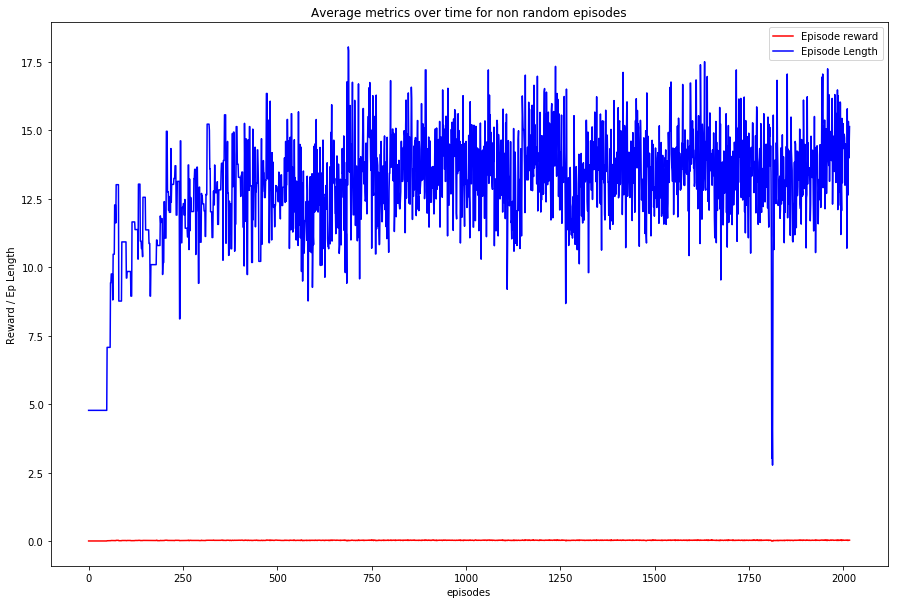

In [14]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrList)), AvgNonRandomrList, color='red', label='Episode reward')
plt.plot(range(len(AvgNonRandomsTimeList)), AvgNonRandomsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

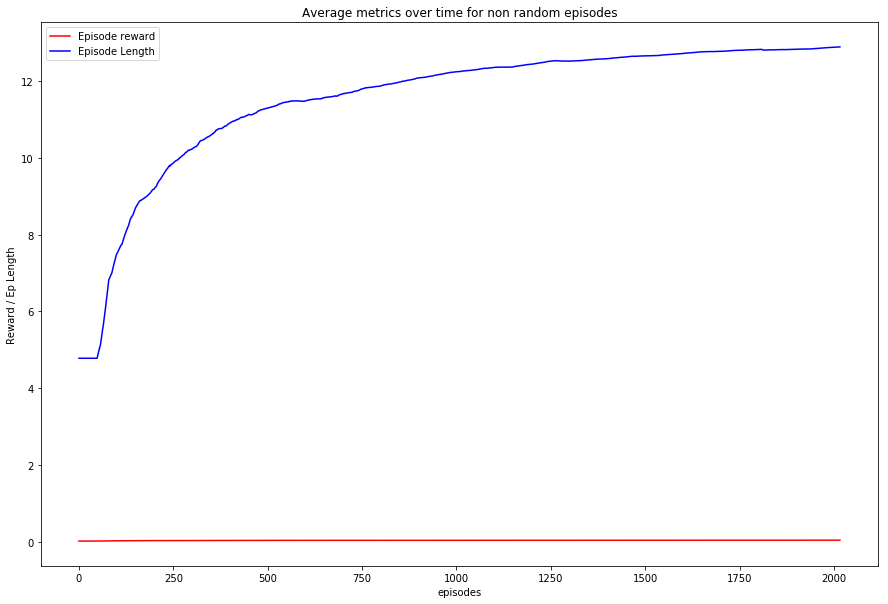

In [15]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrListMA)), AvgNonRandomrListMA, color='red', label='Episode reward')
plt.plot(range(len(AvgNonRandomsTimeListMA)), AvgNonRandomsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

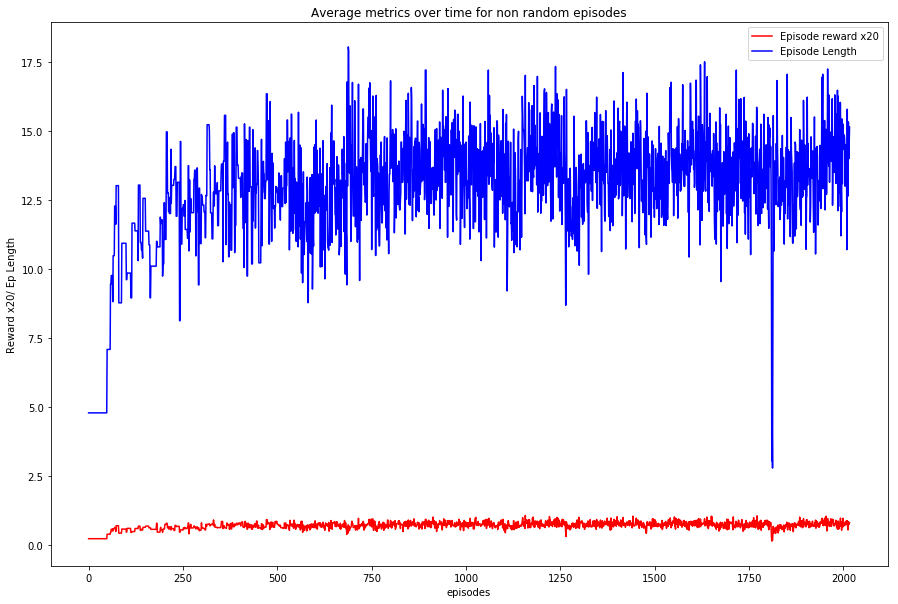

In [16]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrList)), np.array(AvgNonRandomrList)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgNonRandomsTimeList)), AvgNonRandomsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x20/ Ep Length')
plt.legend(loc='best');

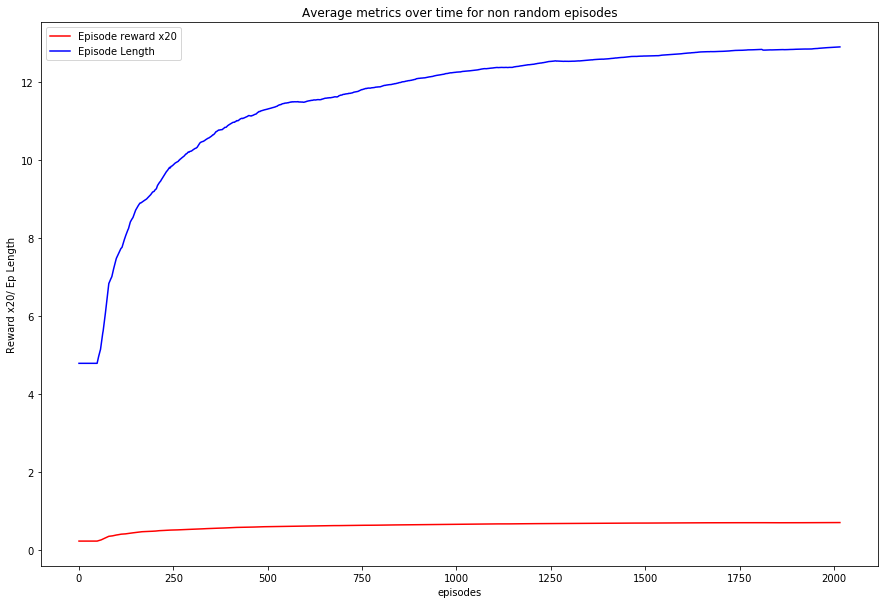

In [17]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrListMA)), np.array(AvgNonRandomrListMA)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgNonRandomsTimeListMA)), AvgNonRandomsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x20/ Ep Length')
plt.legend(loc='best');

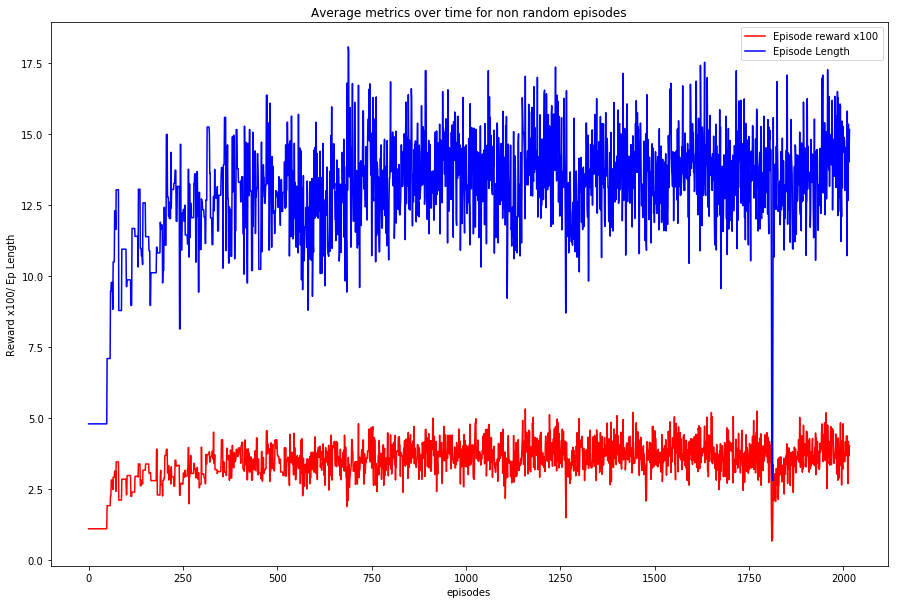

In [18]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrList)), np.array(AvgNonRandomrList)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgNonRandomsTimeList)), AvgNonRandomsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x100/ Ep Length')
plt.legend(loc='best');

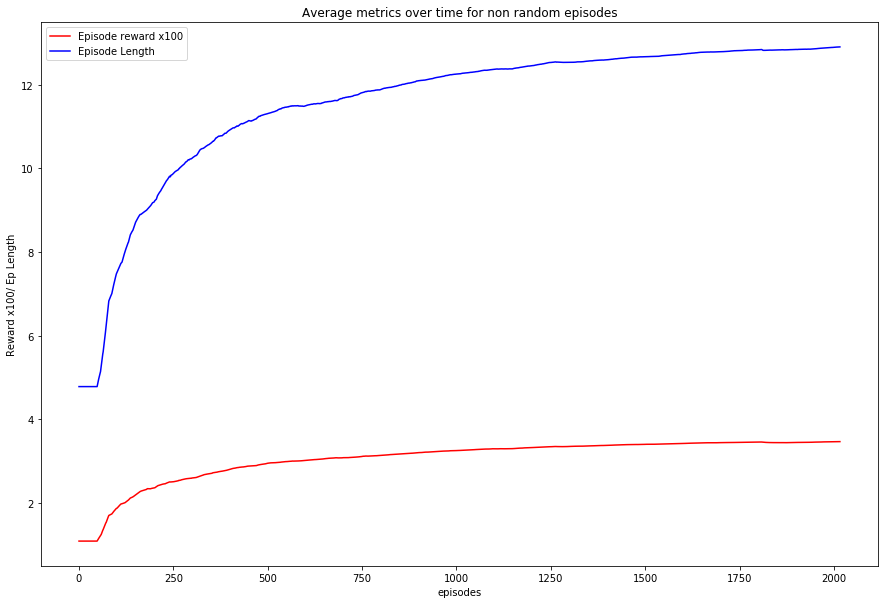

In [19]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrListMA)), np.array(AvgNonRandomrListMA)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgNonRandomsTimeListMA)), AvgNonRandomsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x100/ Ep Length')
plt.legend(loc='best');

# per epoch

In [20]:
AvgrListMAEpoch = movingaverage(AvgrListEpoch)

AvgsTimeListMAEpoch = movingaverage(AvgsTimeListEpoch)

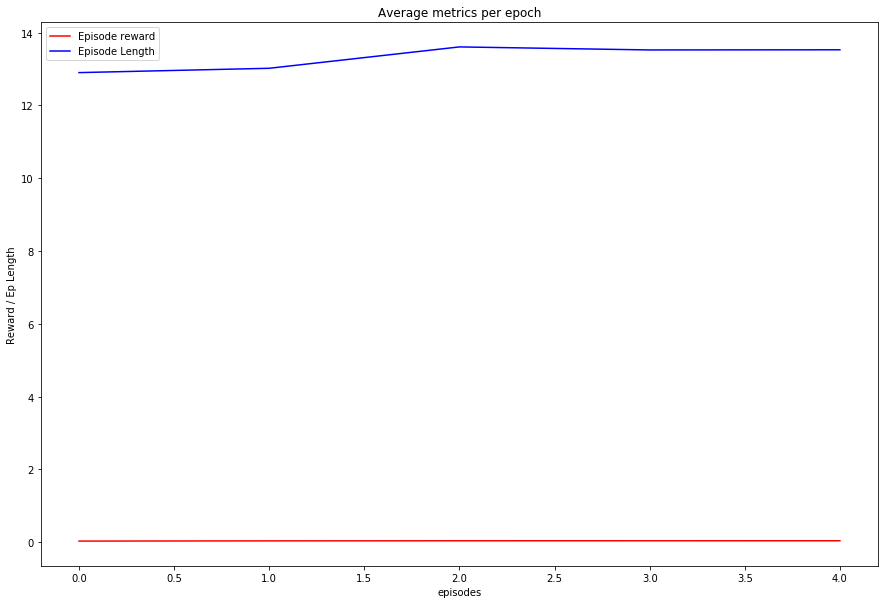

In [21]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListEpoch)), AvgrListEpoch, color='red', label='Episode reward')
plt.plot(range(len(AvgsTimeListEpoch)), AvgsTimeListEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

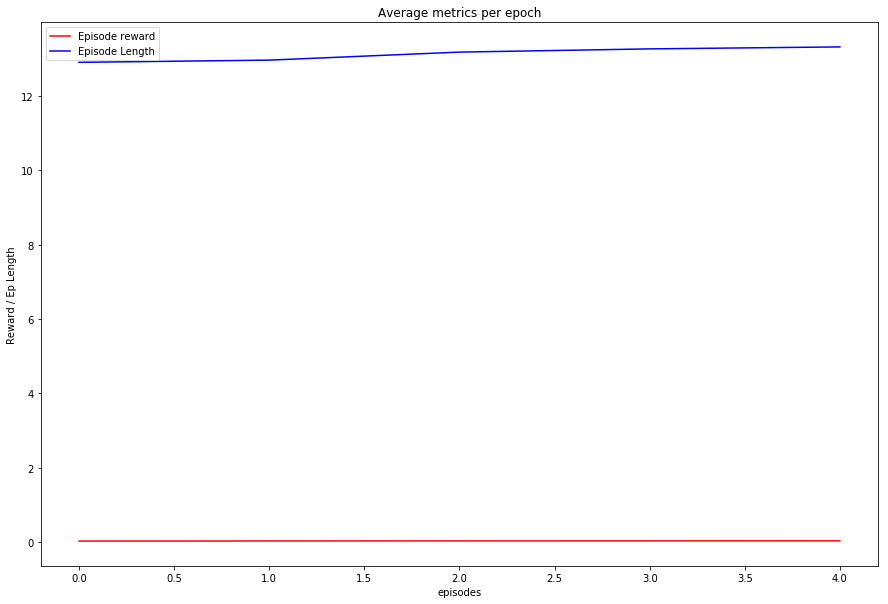

In [22]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListMAEpoch)), AvgrListMAEpoch, color='red', label='Episode reward')
plt.plot(range(len(AvgsTimeListMAEpoch)), AvgsTimeListMAEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

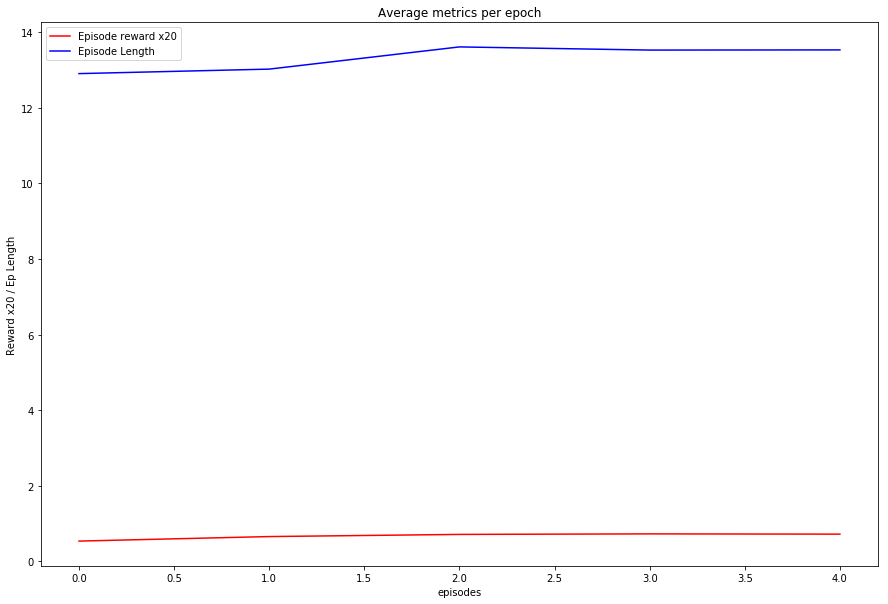

In [23]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListEpoch)), np.array(AvgrListEpoch)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgsTimeListEpoch)), AvgsTimeListEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

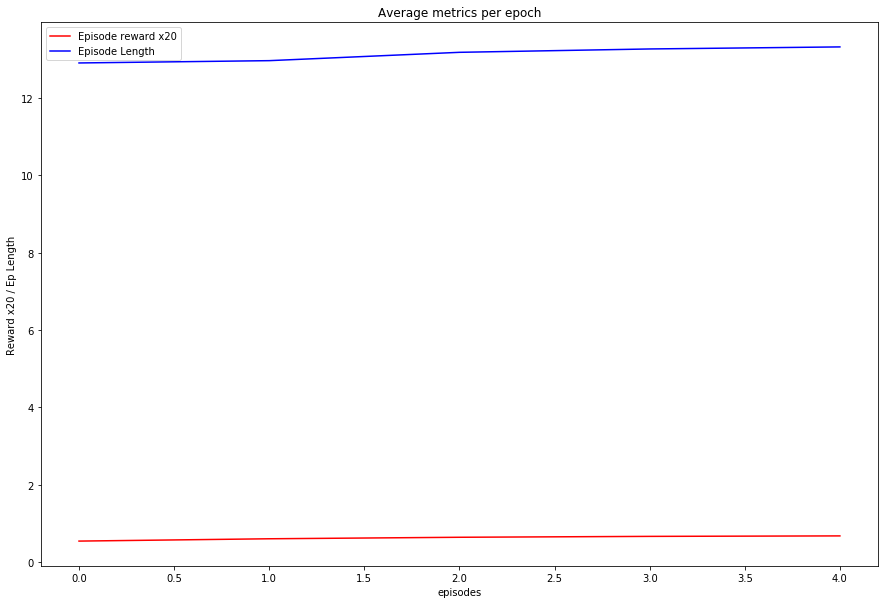

In [24]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListMAEpoch)), np.array(AvgrListMAEpoch)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgsTimeListMAEpoch)), AvgsTimeListMAEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

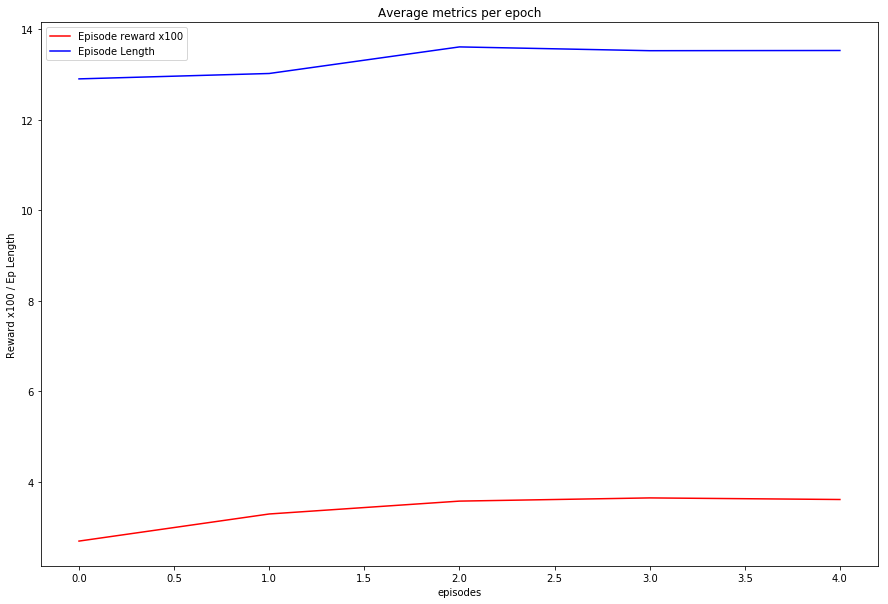

In [25]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(range(len(AvgrListEpoch)), np.array(AvgrListEpoch)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgsTimeListEpoch)), AvgsTimeListEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

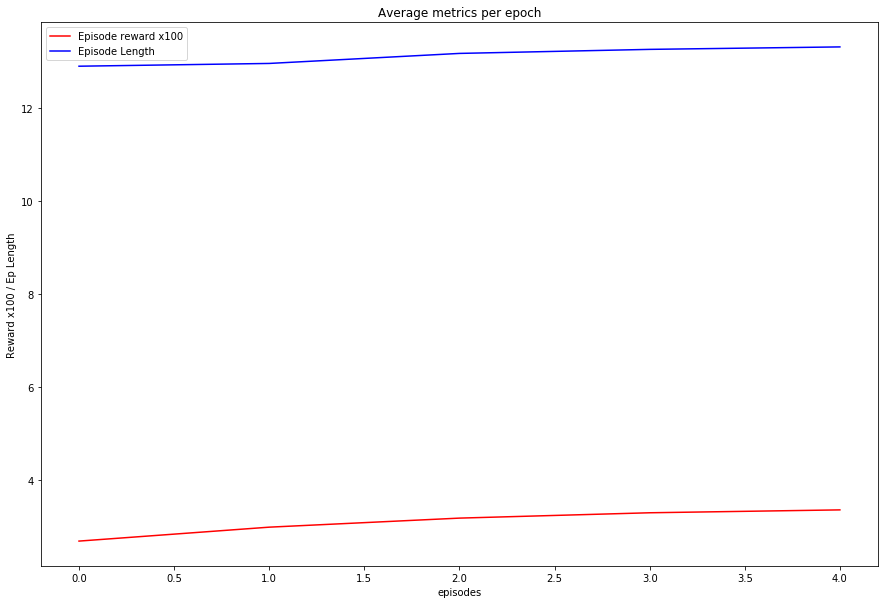

In [26]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(range(len(AvgrListMAEpoch)), np.array(AvgrListMAEpoch)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgsTimeListMAEpoch)), AvgsTimeListMAEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

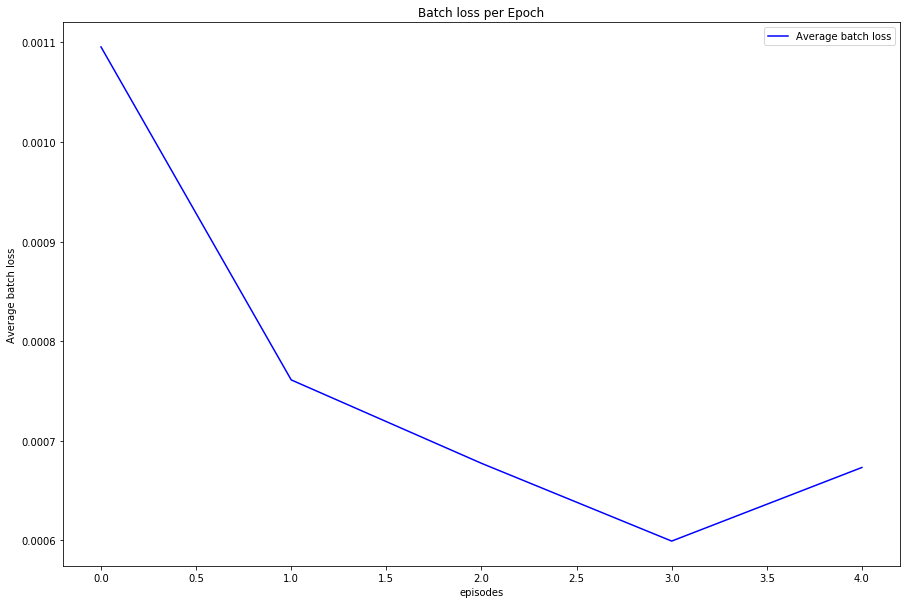

In [27]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgLossListEpoch)), AvgLossListEpoch, color='blue', label='Average batch loss')
#plt.plot(range(len(AvgQSellLossListEpoch)), AvgQSellLossListEpoch, color='red', label='Average batch loss for sell')
plt.title('Batch loss per Epoch')
plt.xlabel('episodes')
plt.ylabel('Average batch loss')
plt.legend(loc='best');

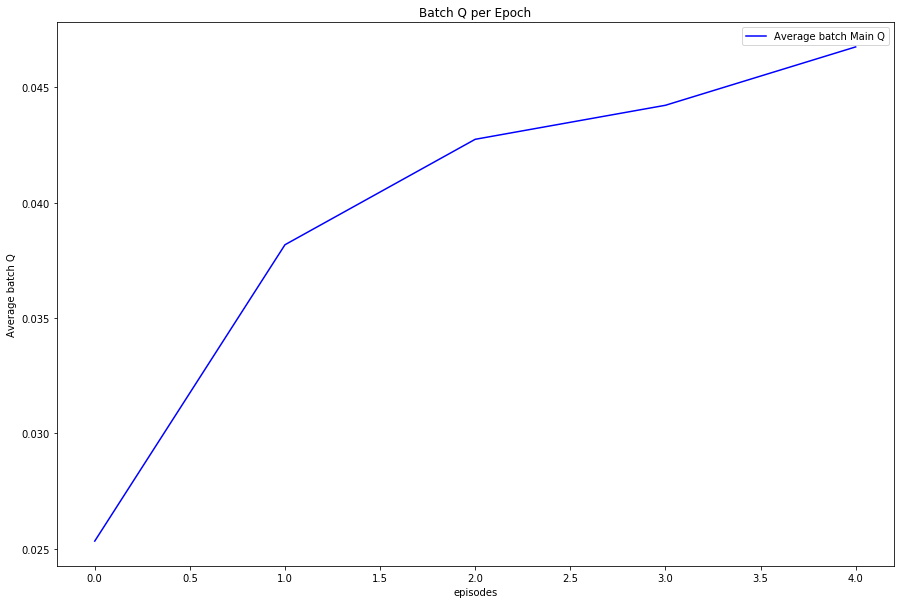

In [28]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgMainQListEpoch)), AvgMainQListEpoch, color='blue', label='Average batch Main Q')
#plt.plot(range(len(AvgTargetQListEpoch)), AvgTargetQListEpoch, color='red', label='Average batch Target Q')
#plt.plot(range(len(AvgMainMaxQListEpoch)), AvgMainMaxQListEpoch, color='green', label='Average batch Main max Q')
#plt.plot(range(len(AvgMainHoldQListEpoch)), AvgMainHoldQListEpoch, color='black', label='Average batch Main hold Q')
#plt.plot(range(len(AvgMainSellQListEpoch)), AvgMainSellQListEpoch, color='orange', label='Average batch Main sell Q')
plt.title('Batch Q per Epoch')
plt.xlabel('episodes')
plt.ylabel('Average batch Q')
plt.legend(loc='best');

In [29]:
AvgrListMA = movingaverage(AvgrList)

AvgsTimeListMA = movingaverage(AvgsTimeList)

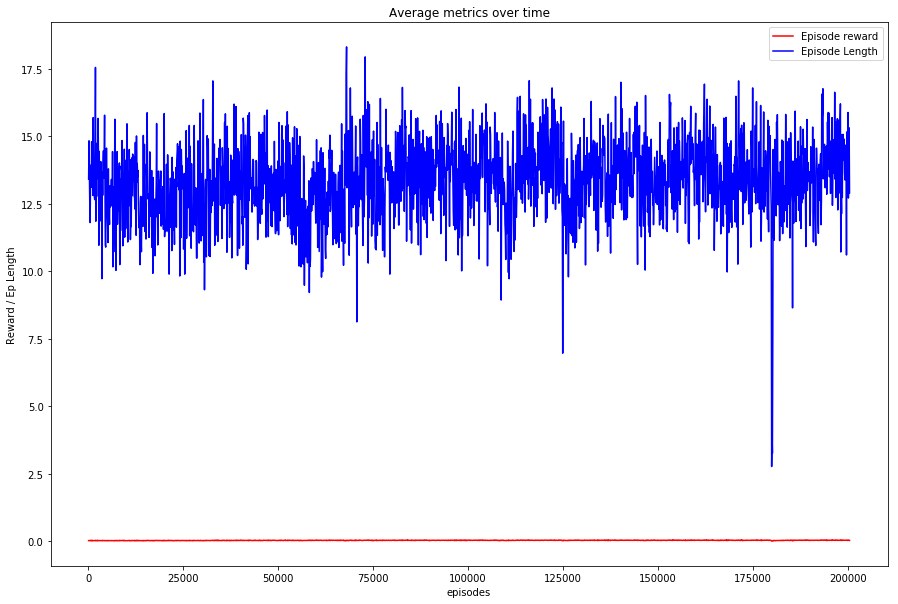

In [30]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

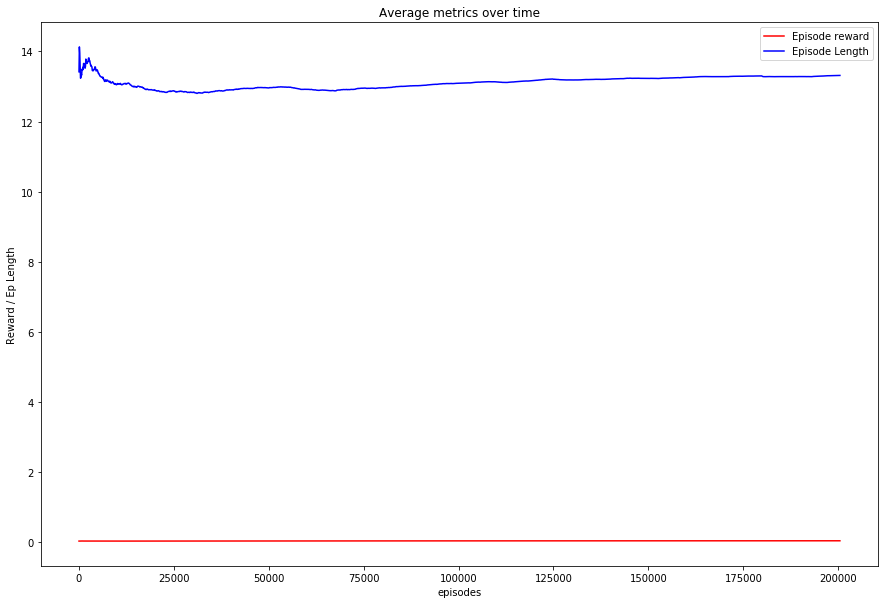

In [31]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrListMA, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

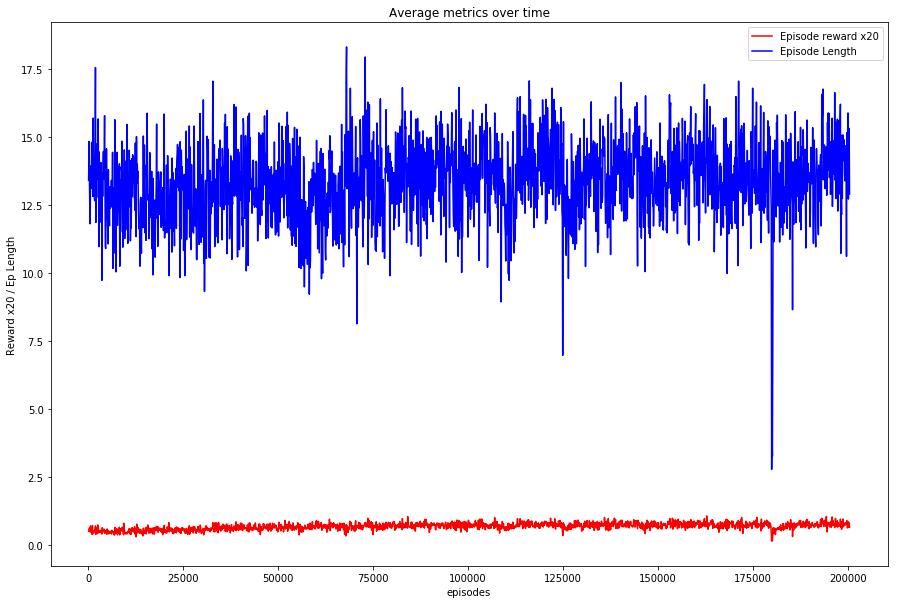

In [32]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

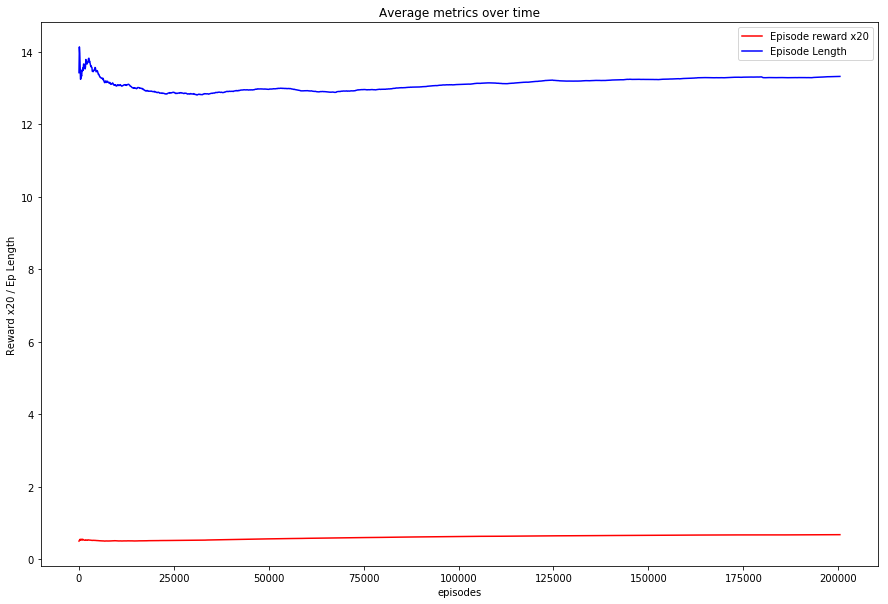

In [33]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrListMA)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

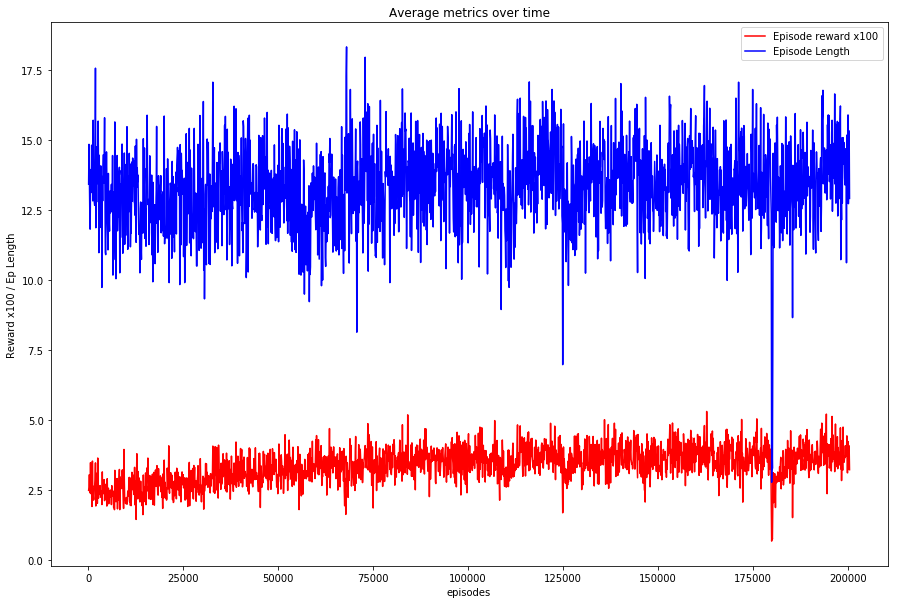

In [34]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

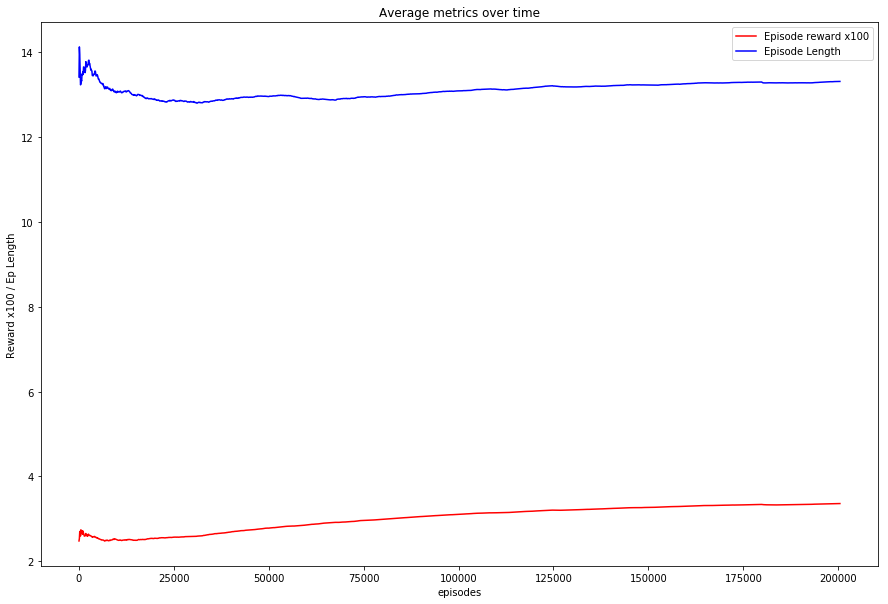

In [35]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(AvgEpisodeList, np.array(AvgrListMA)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

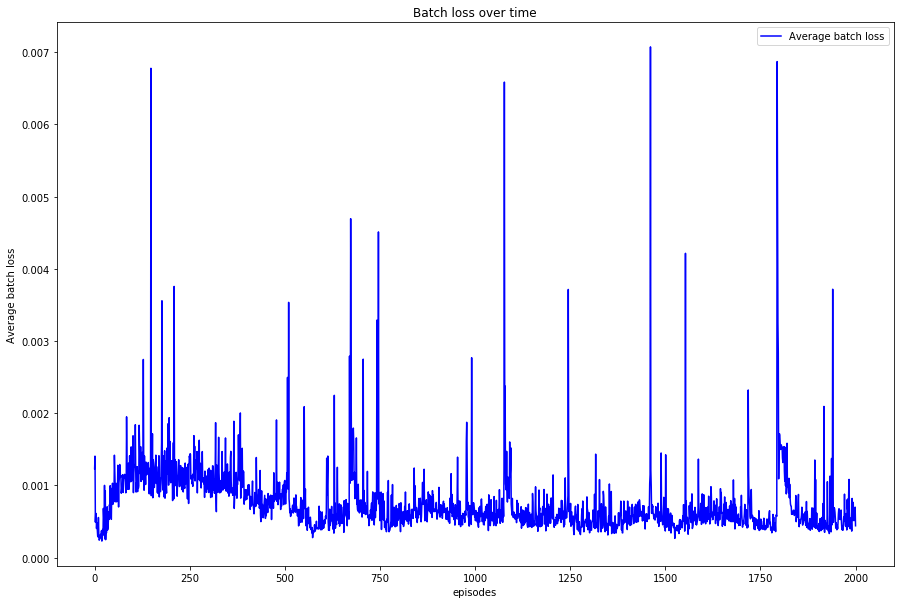

In [36]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgLossList)), AvgLossList, color='blue', label='Average batch loss')
#plt.plot(range(len(AvgQSellLossList)), AvgQSellLossList, color='red', label='Average batch loss for sell')
plt.title('Batch loss over time')
plt.xlabel('episodes')
plt.ylabel('Average batch loss')
plt.legend(loc='best');

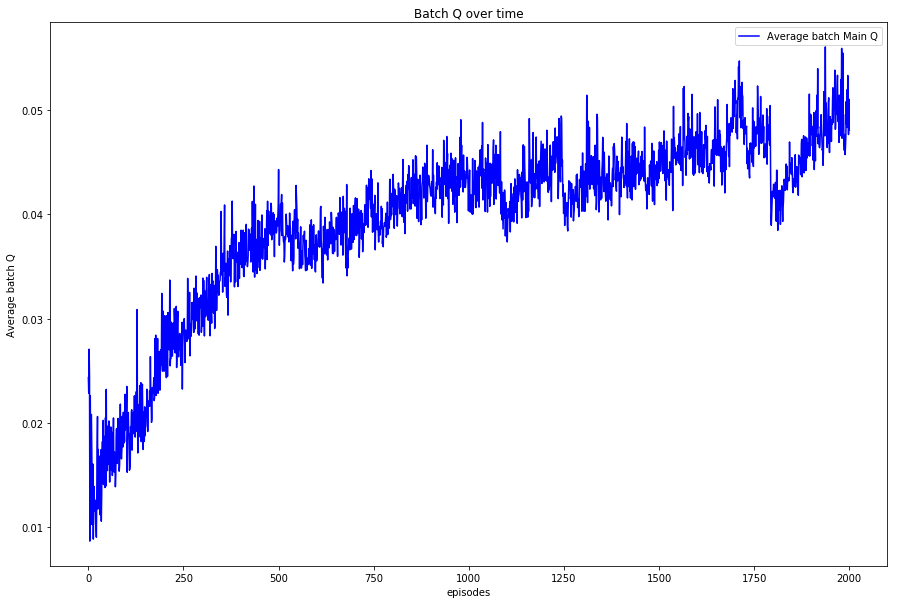

In [37]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgMainQList)), AvgMainQList, color='blue', label='Average batch Main Q')
#plt.plot(range(len(AvgTargetQList)), AvgTargetQList, color='red', label='Average batch Target Q')
#plt.plot(range(len(AvgMainMaxQList)), AvgMainMaxQList, color='green', label='Average batch Main max Q')
#plt.plot(range(len(AvgMainHoldQList)), AvgMainHoldQList, color='black', label='Average batch Main hold Q')
#plt.plot(range(len(AvgMainSellQList)), AvgMainSellQList, color='orange', label='Average batch Main sell Q')
plt.title('Batch Q over time')
plt.xlabel('episodes')
plt.ylabel('Average batch Q')
plt.legend(loc='best');

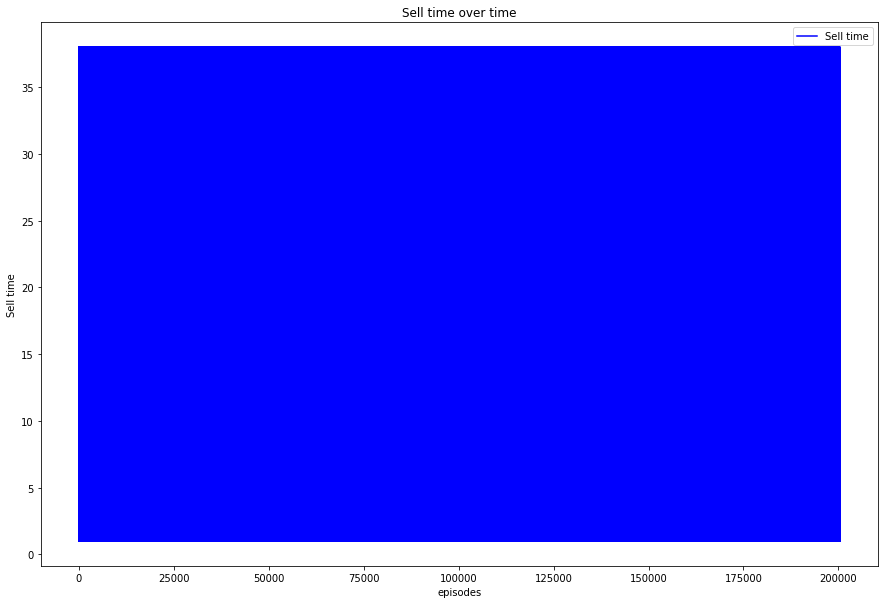

In [38]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

In [39]:
sTimeListMA = movingaverage(sTimeList)

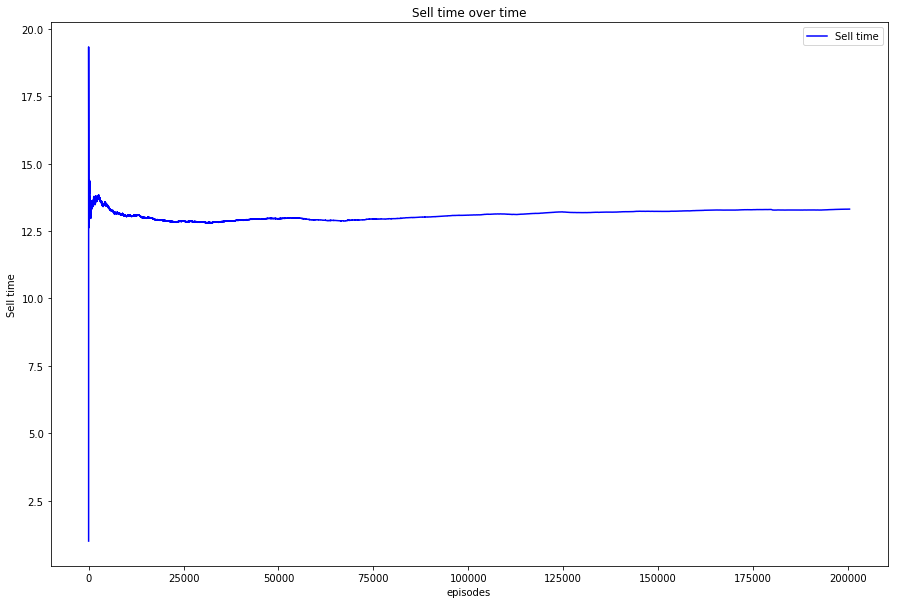

In [40]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeListMA)), sTimeListMA, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

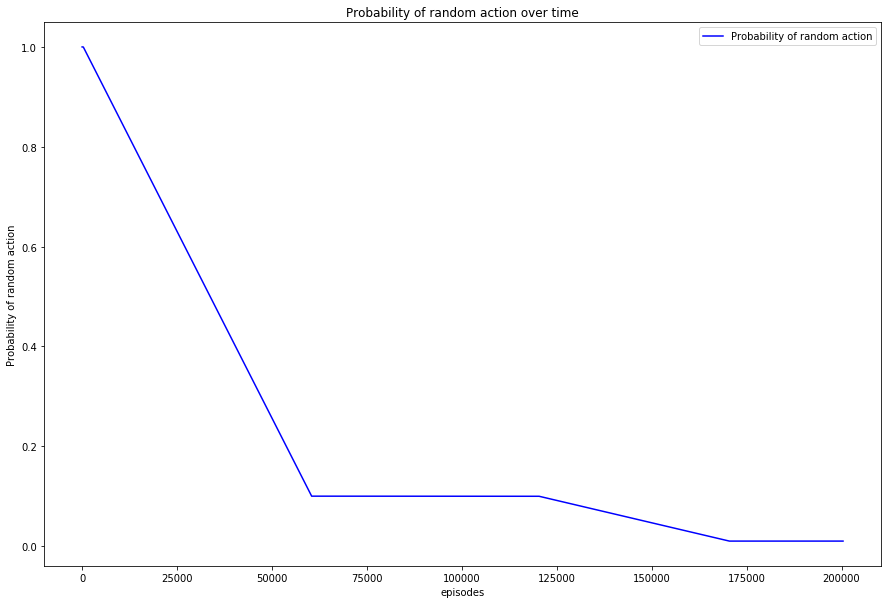

In [41]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(num_episodes), eList, color='blue', label='Probability of random action')
plt.title('Probability of random action over time')
plt.xlabel('episodes')
plt.ylabel('Probability of random action')
plt.legend(loc='best');

### Testing the network

In [12]:
#e = 0.03 #0.01 #The chance of chosing a random action
load_model = True #Whether to load a saved model.
is_training = False

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 110
num_episodes_per_epoch: 7080
min value of stock: 121.705, max value of stock: 147.02499999999998


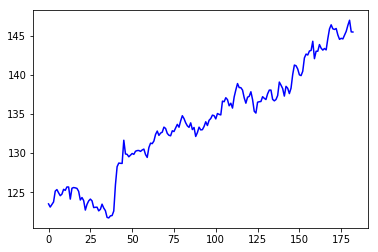

In [43]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [44]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,\
                                   mainQN.state_in:state,mainQN.batch_size:1,\
                                   mainQN.num_quantiles:num_quantile_samples,\
                                   mainQN.quantiles_shape:num_quantile_samples})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_REAL_stocks_version\savedModel\IQN_arch0-option_T50-history_t15-softUpdateTrue-tau0.001-huber_lossTrue-freq100-batch64-capacity3000-lambda0.0025-final
episode 100: 	0.012645914061363188	9.51
episode 200: 	0.017495305147213612	9.55
episode 300: 	0.014447696121744243	9.77
episode 400: 	0.015659389557057448	9.45
episode 500: 	0.015059103433077545	10.39
episode 600: 	0.014422724520851117	9.18
episode 700: 	0.01623965490967279	9.03
episode 800: 	0.014279026377460972	8.74
episode 900: 	0.014166603395647898	9.64
episode 1000: 	0.0126651213684844	8.45
episode 1100: 	0.015398020164918874	11.18
episode 1200: 	0.014752752695652648	9.55
episode 1300: 	0.017831785551451054	10.12
episode 1400: 	0.015471507501191261	10.65
episode 1500: 	0.014380228480481802	10.57
episode 1600: 	0.01349403486597

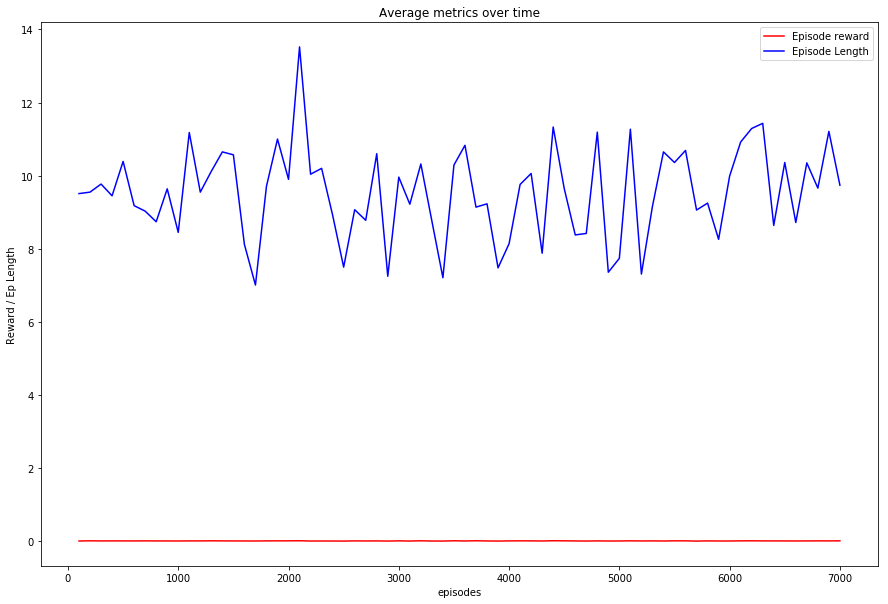

In [46]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

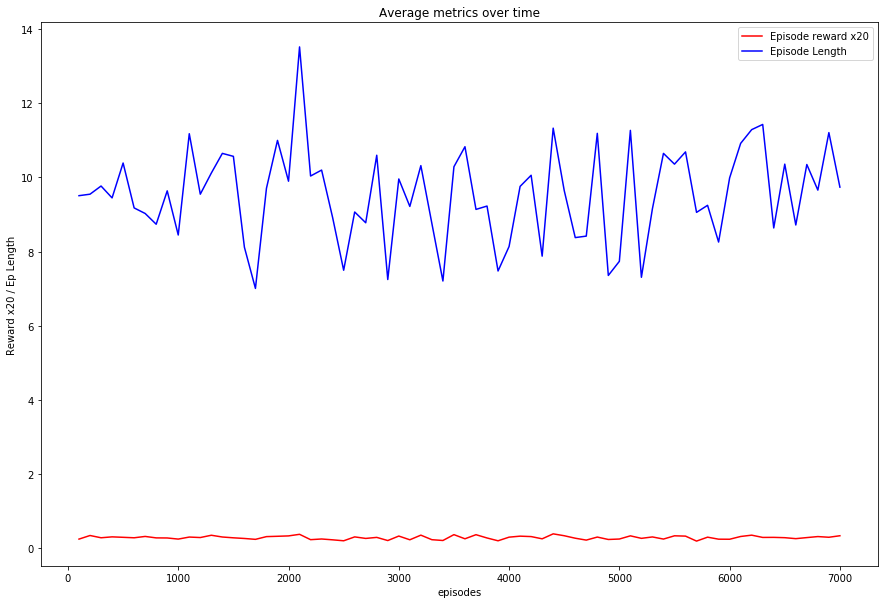

In [47]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

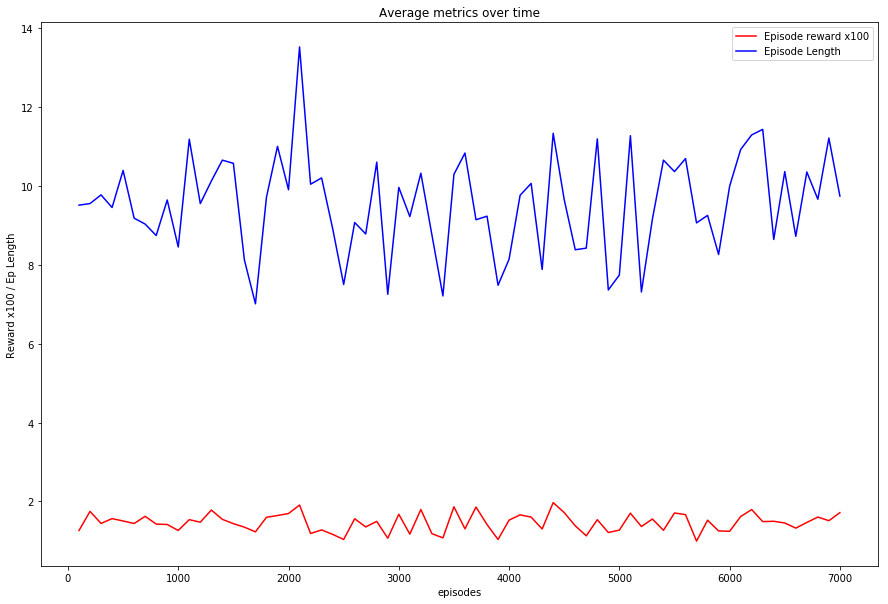

In [48]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

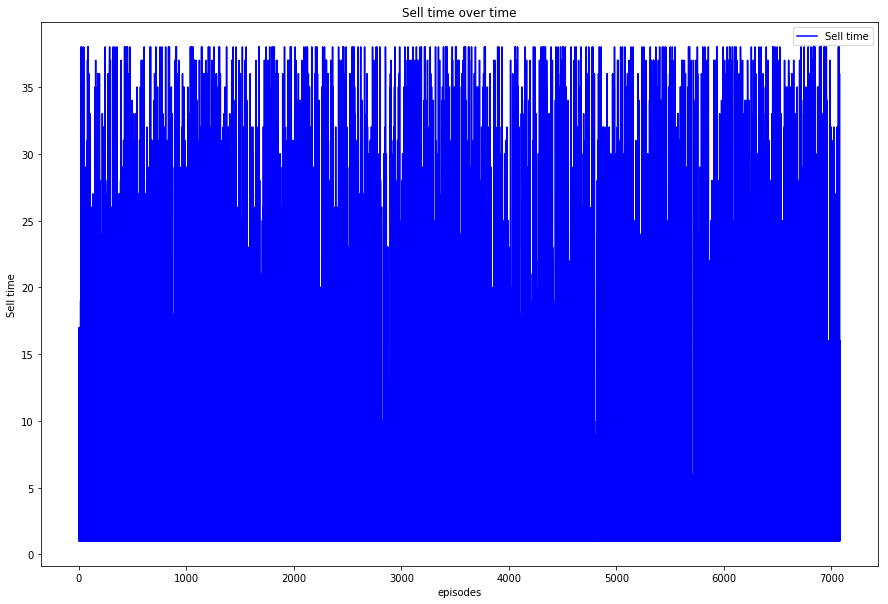

In [49]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select day of Min price over history [Benchmark]

In [50]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'MinValue' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MinValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MinValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] <= min(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.008499253350724625	9.51	0.009999999999278975
episode 200: 	0.012840728967982738	11.36	0.009999999999278975
episode 300: 	0.013252953811328716	12.84	0.009999999999278975
episode 400: 	0.010144169278408981	10.25	0.009999999999278975
episode 500: 	0.01477261023855517	11.73	0.009999999999278975
episode 600: 	0.012624041293153573	10.62	0.009999999999278975
episode 700: 	0.012685152741312978	10.25	0.009999999999278975
episode 800: 	0.010183184835164791	9.14	0.009999999999278975
episode 900: 	0.011158109887987808	12.1	0.009999999999278975
episode 1000: 	0.014037358874459354	10.62	0.009999999999278975
episode 1100: 	0.015406984565344941	12.84	0.009999999999278975
episode 1200: 	0.012084104352434758	10.99	0.009999999999278975
episode 1300: 	0.013658610130456949	12.84	0.009999999999278975
episode 1400: 	0.013634256076332053	11.36	0.009999999999278975
episode 1500: 	0.010510622175477248	11.73	0.009999999999278975
episode 1600: 	0.015229153231330395	10.99	0.009999999999278975
episo

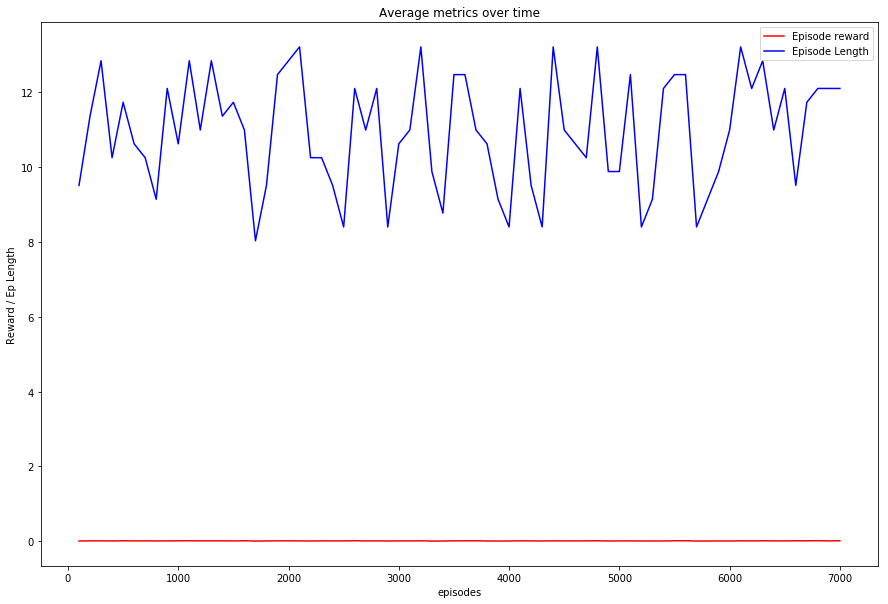

In [51]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

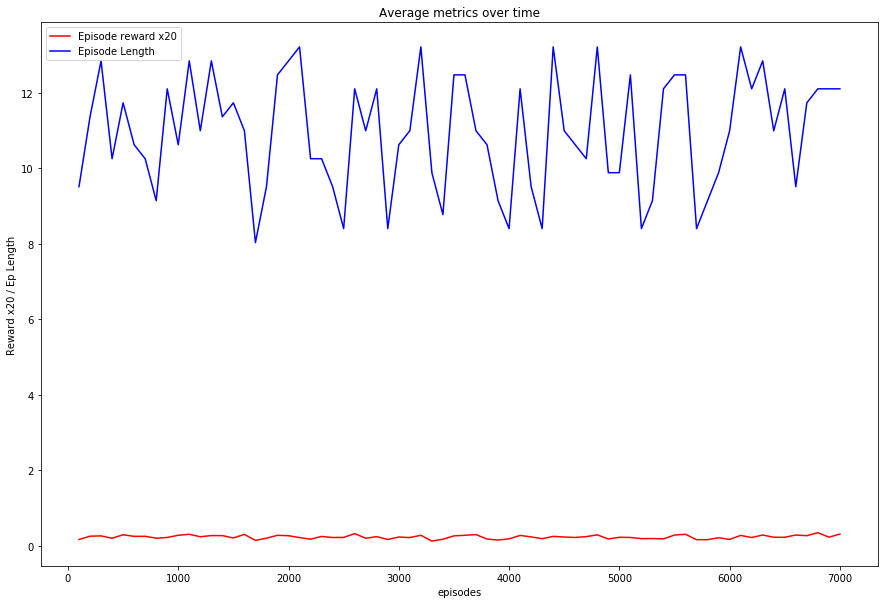

In [52]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

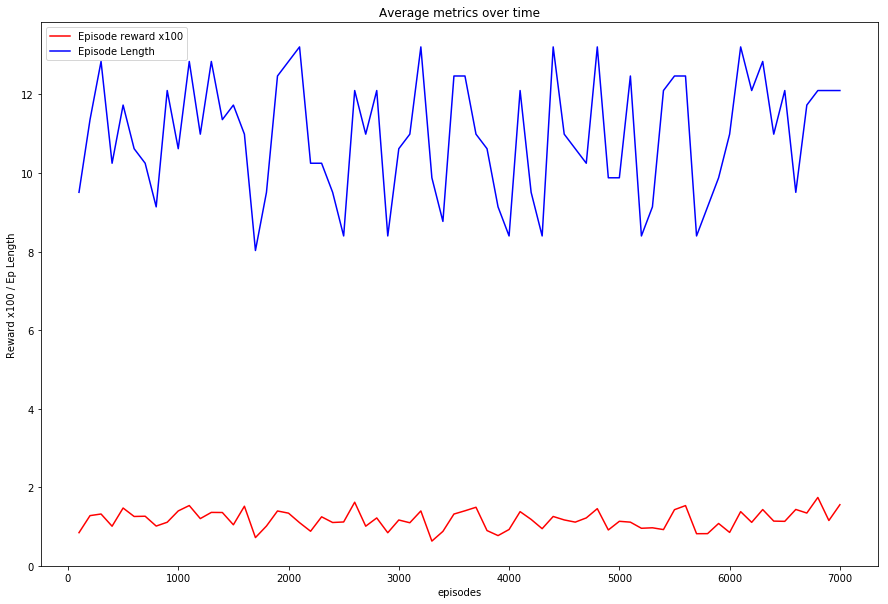

In [53]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

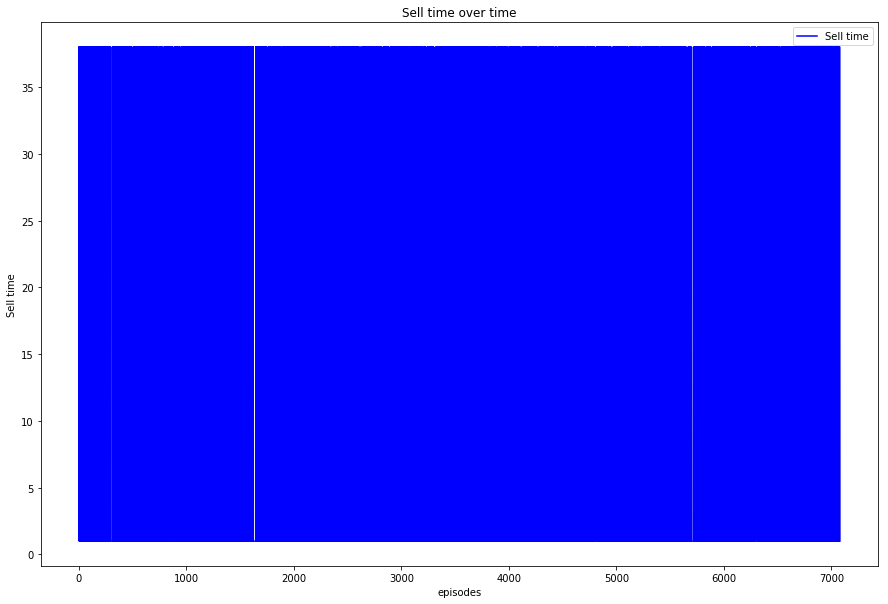

In [54]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select day of Max price over history [Benchmark]

In [55]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'MaxValue' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.008499253350724625	9.51	0.009999999999278975
episode 200: 	0.012840728967982738	11.36	0.009999999999278975
episode 300: 	0.013252953811328716	12.84	0.009999999999278975
episode 400: 	0.010144169278408981	10.25	0.009999999999278975
episode 500: 	0.01477261023855517	11.73	0.009999999999278975
episode 600: 	0.012624041293153573	10.62	0.009999999999278975
episode 700: 	0.012685152741312978	10.25	0.009999999999278975
episode 800: 	0.010183184835164791	9.14	0.009999999999278975
episode 900: 	0.011158109887987808	12.1	0.009999999999278975
episode 1000: 	0.014037358874459354	10.62	0.009999999999278975
episode 1100: 	0.015406984565344941	12.84	0.009999999999278975
episode 1200: 	0.012084104352434758	10.99	0.009999999999278975
episode 1300: 	0.013658610130456949	12.84	0.009999999999278975
episode 1400: 	0.013634256076332053	11.36	0.009999999999278975
episode 1500: 	0.010510622175477248	11.73	0.009999999999278975
episode 1600: 	0.015229153231330395	10.99	0.009999999999278975
episo

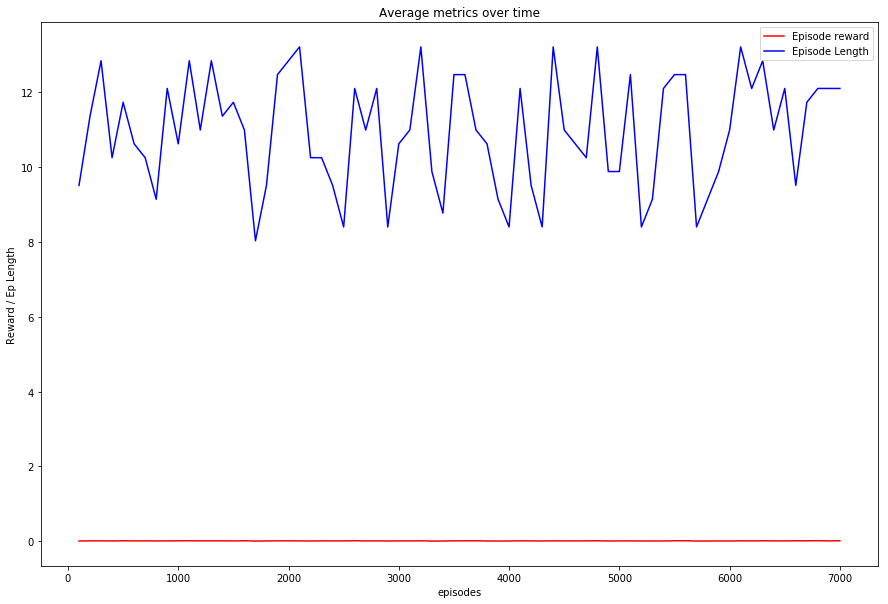

In [57]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

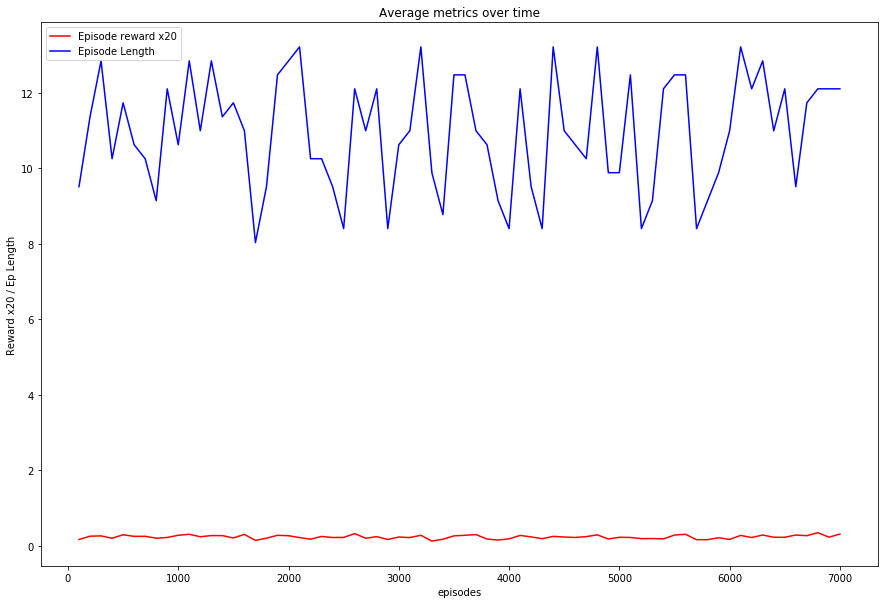

In [58]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

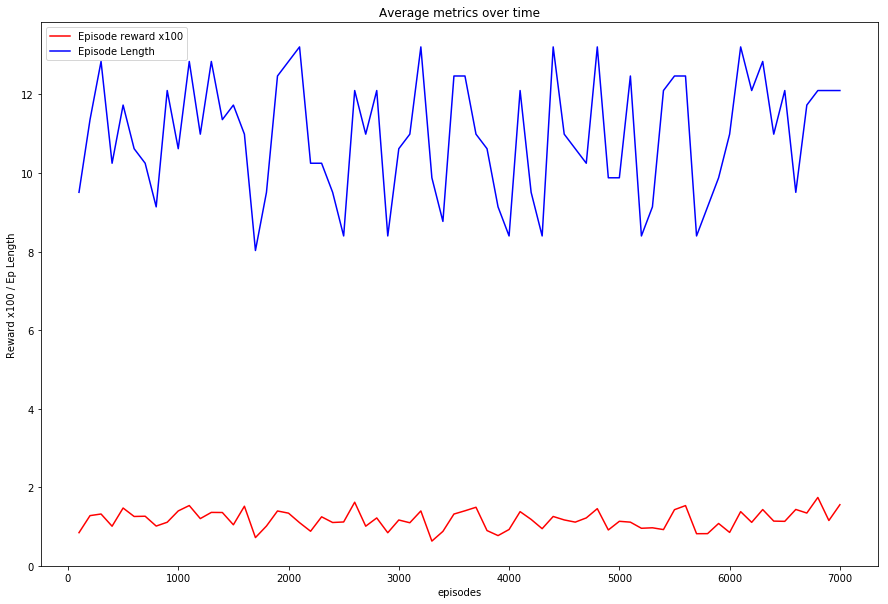

In [59]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

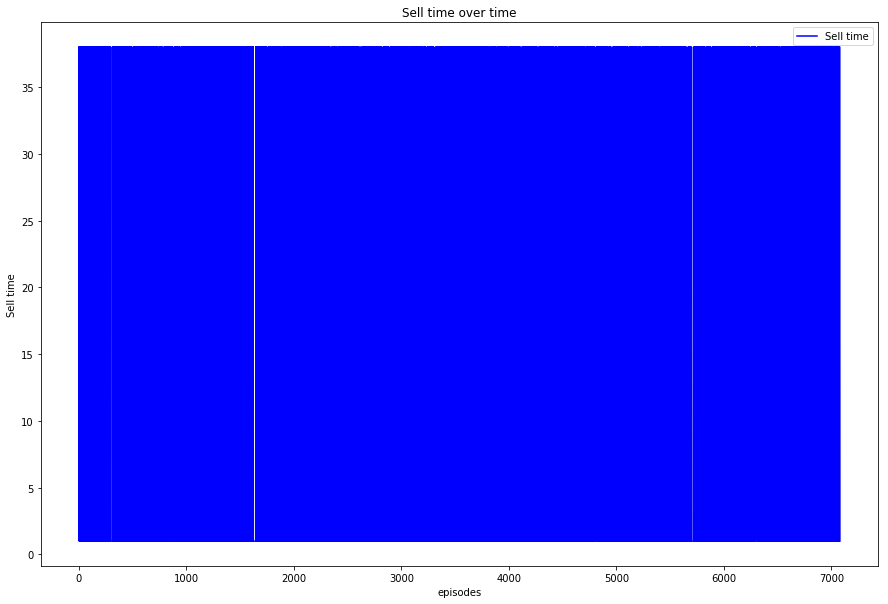

In [60]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select random day over history to sell [Benchmark]

In [61]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.0097632388941704	9.13	0.009999999999278975
episode 200: 	0.012570394170387831	9.68	0.009999999999278975
episode 300: 	0.01442489620841279	10.69	0.009999999999278975
episode 400: 	0.011448907505339622	9.33	0.009999999999278975
episode 500: 	0.013189010985088234	10.78	0.009999999999278975
episode 600: 	0.013796800367251954	9.48	0.009999999999278975
episode 700: 	0.014763394043047742	9.39	0.009999999999278975
episode 800: 	0.012696145224976805	9.18	0.009999999999278975
episode 900: 	0.012294080438419739	10.26	0.009999999999278975
episode 1000: 	0.013212852928194336	8.95	0.009999999999278975
episode 1100: 	0.013053968454308706	10.86	0.009999999999278975
episode 1200: 	0.011595972517554322	9.46	0.009999999999278975
episode 1300: 	0.01324434723662502	10.8	0.009999999999278975
episode 1400: 	0.015138128240810858	10.39	0.009999999999278975
episode 1500: 	0.01409266696766516	10.33	0.009999999999278975
episode 1600: 	0.014663485702560621	9.6	0.009999999999278975
episode 1700: 	0.

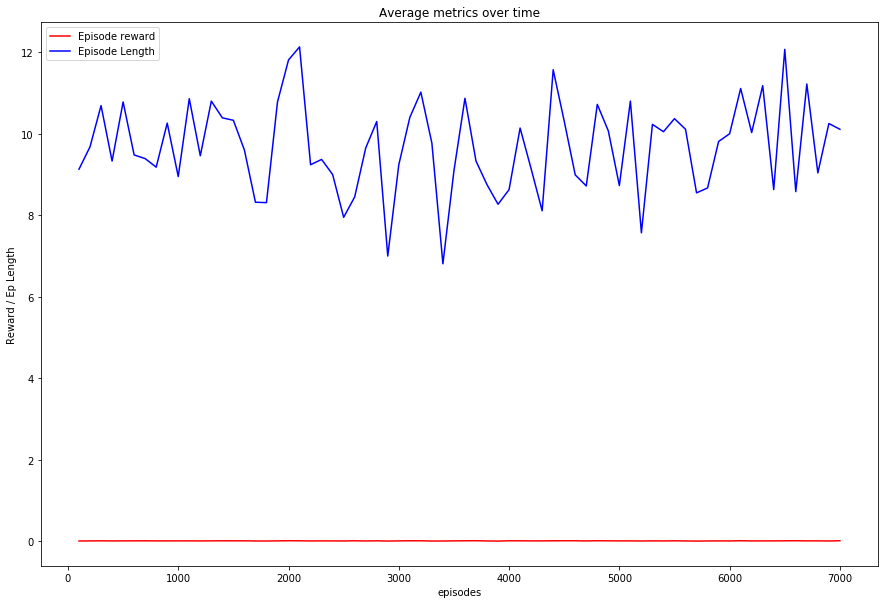

In [63]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

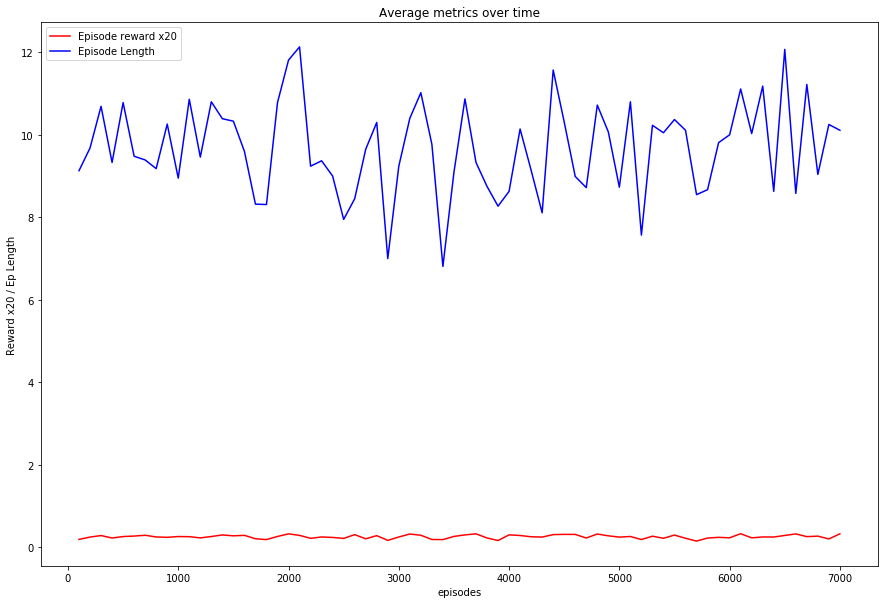

In [64]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

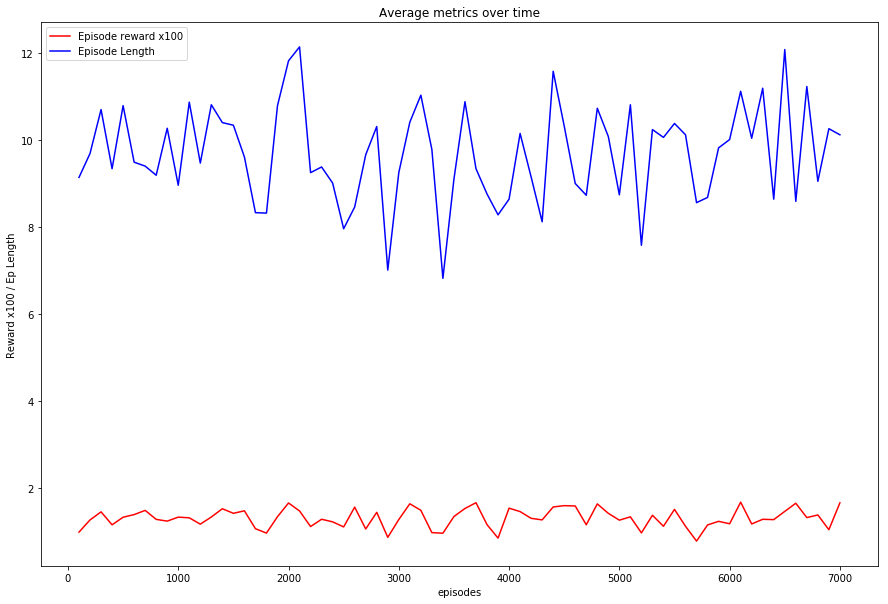

In [65]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

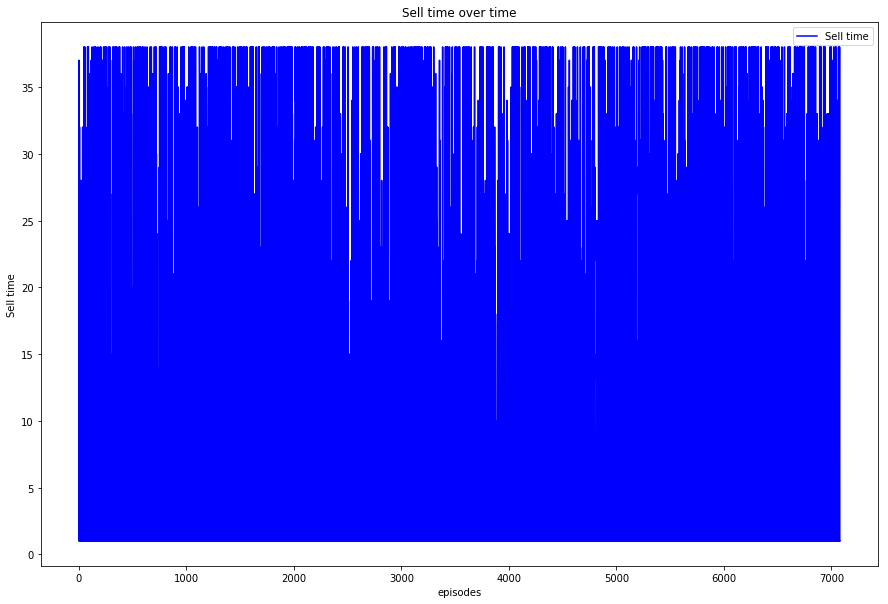

In [66]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select last day over history to sell [Benchmark]

In [67]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'LastDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []  

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'LastDay':
          sell_time = max_epLength - 1  
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'LastDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.008499253350724625	9.51	0.009999999999278975
episode 200: 	0.012840728967982738	11.36	0.009999999999278975
episode 300: 	0.013252953811328716	12.84	0.009999999999278975
episode 400: 	0.010144169278408981	10.25	0.009999999999278975
episode 500: 	0.01477261023855517	11.73	0.009999999999278975
episode 600: 	0.012624041293153573	10.62	0.009999999999278975
episode 700: 	0.012685152741312978	10.25	0.009999999999278975
episode 800: 	0.010183184835164791	9.14	0.009999999999278975
episode 900: 	0.011158109887987808	12.1	0.009999999999278975
episode 1000: 	0.014037358874459354	10.62	0.009999999999278975
episode 1100: 	0.015406984565344941	12.84	0.009999999999278975
episode 1200: 	0.012084104352434758	10.99	0.009999999999278975
episode 1300: 	0.013658610130456949	12.84	0.009999999999278975
episode 1400: 	0.013634256076332053	11.36	0.009999999999278975
episode 1500: 	0.010510622175477248	11.73	0.009999999999278975
episode 1600: 	0.015229153231330395	10.99	0.009999999999278975
episo

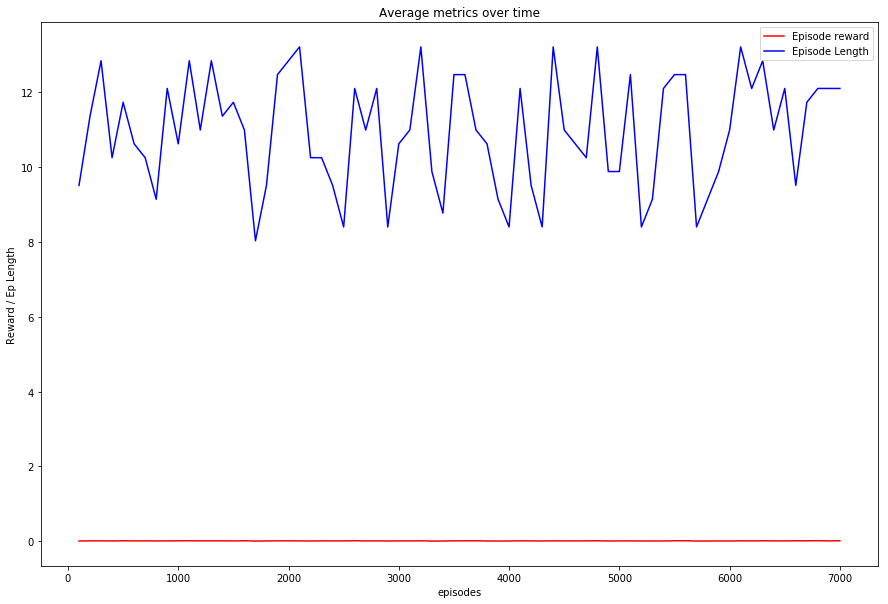

In [69]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

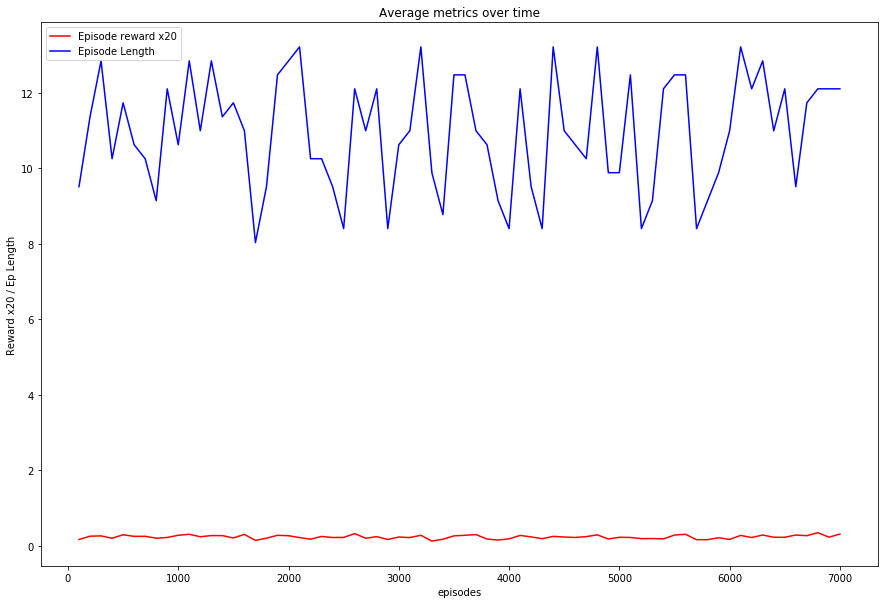

In [70]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

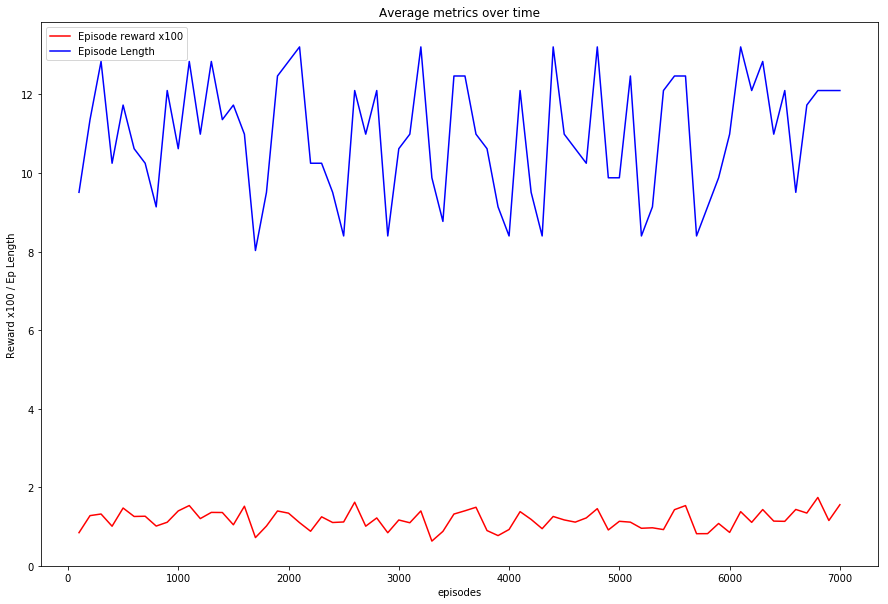

In [71]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

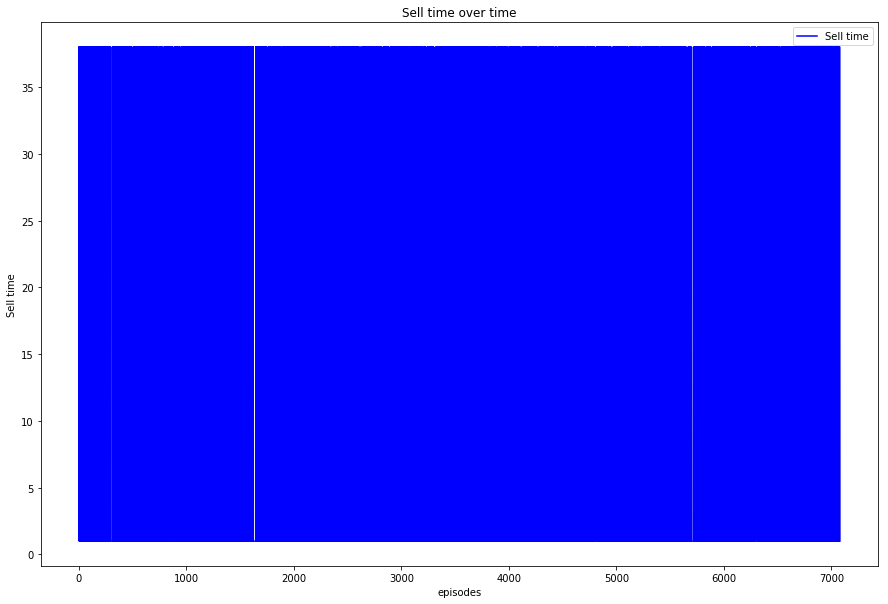

In [72]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select first day over history to sell [Benchmark]

In [73]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'FirstDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = [] 

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'FirstDay':
          sell_time = build_warm_up_state_t 
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'FirstDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.006098382091840449	4.7	0.009999999999278975
episode 200: 	0.0077959935294856664	3.59	0.009999999999278975
episode 300: 	0.009963998291505254	7.29	0.009999999999278975
episode 400: 	0.009920367194459559	7.29	0.009999999999278975
episode 500: 	0.010804201451207364	4.7	0.009999999999278975
episode 600: 	0.008789317843062201	4.7	0.009999999999278975
episode 700: 	0.006216129333087007	3.59	0.009999999999278975
episode 800: 	0.007372756091595433	3.59	0.009999999999278975
episode 900: 	0.008352089470008671	5.44	0.009999999999278975
episode 1000: 	0.006427139593864488	3.59	0.009999999999278975
episode 1100: 	0.012410093795632455	7.29	0.009999999999278975
episode 1200: 	0.007146767553400708	5.44	0.009999999999278975
episode 1300: 	0.01024953629386024	6.55	0.009999999999278975
episode 1400: 	0.010491457133852475	5.81	0.009999999999278975
episode 1500: 	0.007758969982482943	5.81	0.009999999999278975
episode 1600: 	0.008097860234039354	6.55	0.009999999999278975
episode 1700: 	0.005

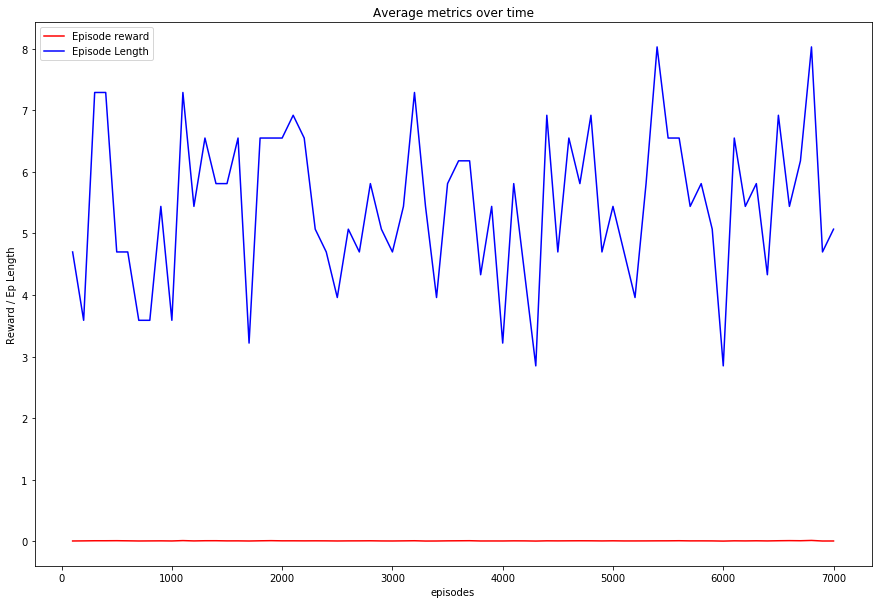

In [74]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

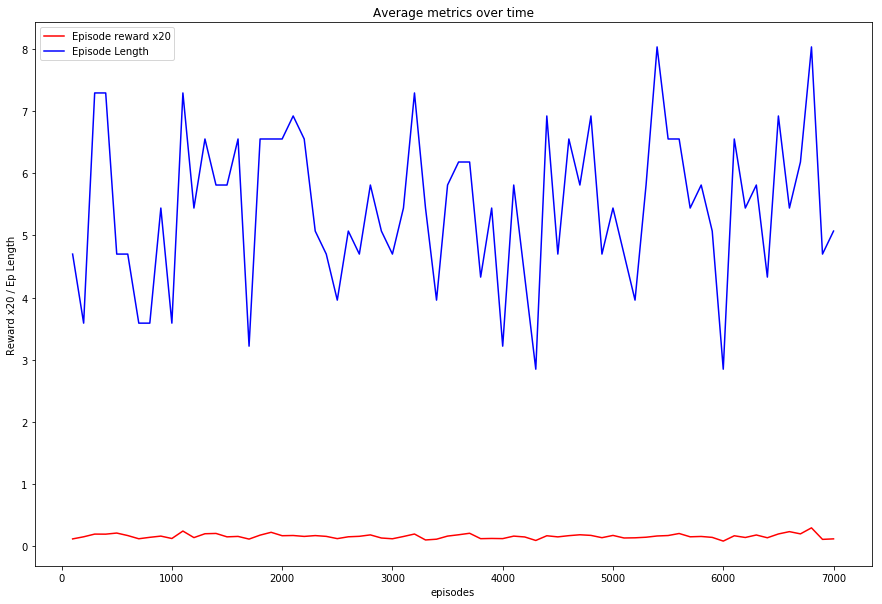

In [75]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

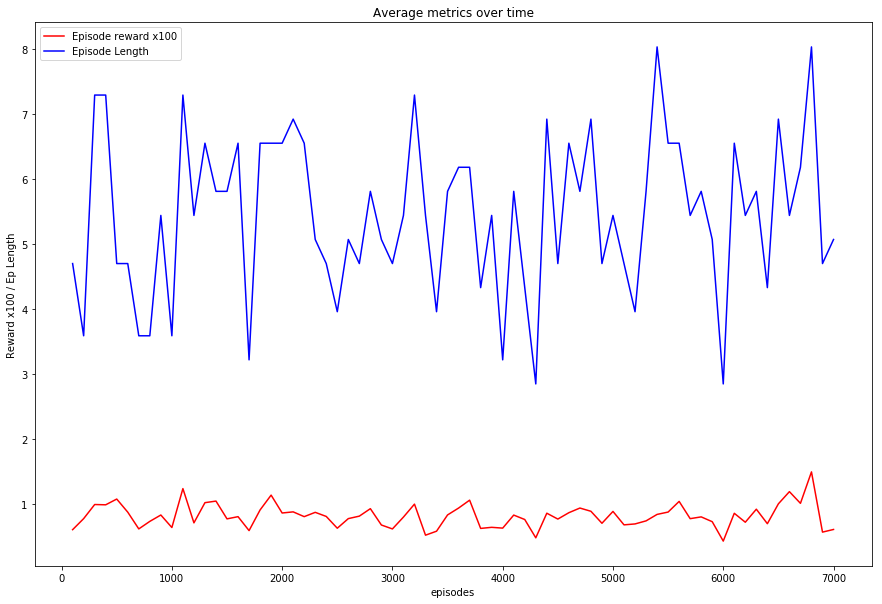

In [76]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

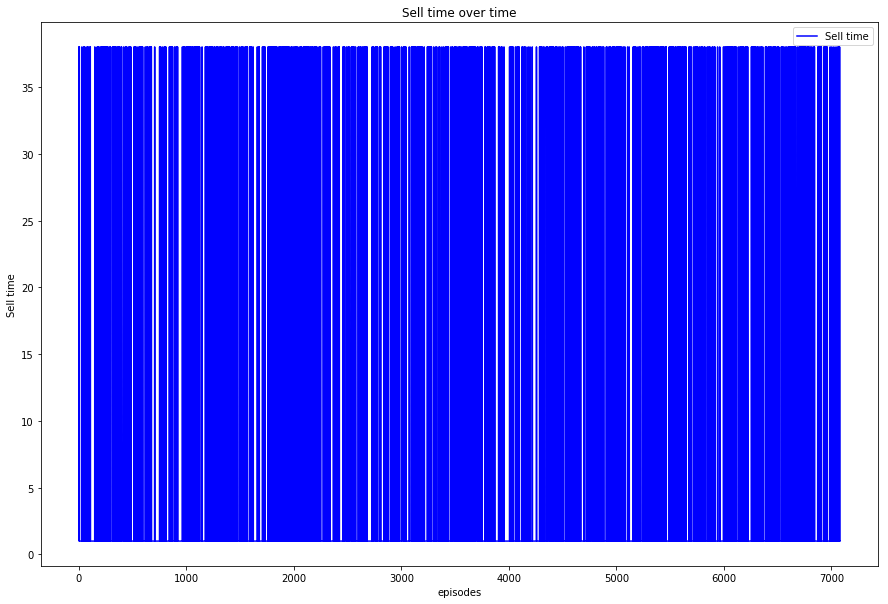

In [77]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Validation part

['HPQ', 'AAPL', 'GOOG', 'UPS', 'JNJ', 'MSFT', 'PG', 'TSN', 'USA', 'TEX', 'SAM', 'SALT', 'TLYS', 'TRQ', 'TRNO', 'TNP', 'TJX', 'TPX', 'FB', 'JPM', 'V', 'BAC', 'MA', 'HD', 'TSM', 'DIS', 'INTC', 'VZ', 'RDS-B', 'TM', 'CVX', 'WFC', 'NVS', 'KO', 'MRK', 'CMCSA', 'SAP', 'CHL', 'UL', 'BUD', 'UN', 'WFC', 'MDT', 'HSBC', 'MCD', 'NKE', 'ADBE', 'CRM', 'TOT', 'PTR', 'COST', 'PM', 'AMGN', 'ABBV', 'HON', 'T', 'GM', 'CVS', 'UNH', 'XOM', 'BRK-A', 'WMT', 'MCK', 'AAT', 'ABC', 'ACRE', 'FN', 'FNB', 'FORD', 'KRG', 'PEG', 'TG', 'NFLX', 'ACN', 'UTX', 'LMT', 'NVDA', 'AVGO', 'AZN', 'TMO', 'UNP', 'LFC', 'BHP', 'SNY', 'BBL', 'NEE', 'TXN', 'LLY', 'QCOM', 'DHR', 'CHTR', 'SBUX', 'MMM', 'AXP', 'HDB', 'TD', 'NVO', 'ASML', 'RY', 'CSCO', 'ORCL', 'C']
[*********************100%***********************]  1 of 1 completed
##HPQmin date: 2017-11-10 00:00:00max date: 2019-12-10 00:00:00
min value of data: 16.05500030517578, max value of data: 26.649999618530273
train_size: 210
test_size: 313
[*********************100%***********

[*********************100%***********************]  1 of 1 completed
##ACREmin date: 2017-11-10 00:00:00max date: 2019-12-09 00:00:00
min value of data: 12.070000171661377, max value of data: 15.755000114440918
train_size: 209
test_size: 313
[*********************100%***********************]  1 of 1 completed
##FNmin date: 2017-11-10 00:00:00max date: 2019-12-09 00:00:00
min value of data: 24.55500030517578, max value of data: 61.55500030517578
train_size: 209
test_size: 313
[*********************100%***********************]  1 of 1 completed
##FNBmin date: 2017-11-10 00:00:00max date: 2019-12-09 00:00:00
min value of data: 9.524999618530273, max value of data: 14.789999961853027
train_size: 209
test_size: 313
[*********************100%***********************]  1 of 1 completed
##FORDmin date: 2017-11-10 00:00:00max date: 2019-12-09 00:00:00
min value of data: 0.949999988079071, max value of data: 3.3899998664855957
train_size: 209
test_size: 313
[*********************100%*************

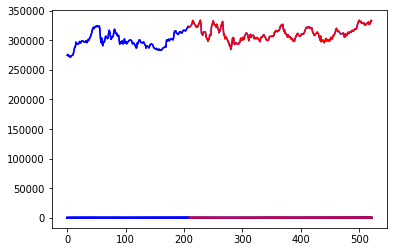

In [13]:
stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ups.us.txt', #'ibm.us.txt'
              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',
              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',
              'trno.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt', #, 'trk.us.txt'
              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',
               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',
               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',
               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',
              'mrk.us.txt', 'cmcsa.us.txt', #'pfe.us.txt', 'ba.us.txt',
               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',
               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',
              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',
               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', #'bp.us.txt',
               'pm.us.txt', 'amgn.us.txt', 'abbv.us.txt', 'hon.us.txt']

stock_names_2 = ['t.us.txt', 'gm.us.txt', 'cvs.us.txt', 'unh.us.txt',
               'xom.us.txt', 'brk-a.us.txt', 'wmt.us.txt', 'mck.us.txt',
               'aat.us.txt', 'abc.us.txt', 'acre.us.txt', #'acta.us.txt',
               'fn.us.txt','fnb.us.txt', 'ford.us.txt', 'krg.us.txt',
              'peg.us.txt', 'tg.us.txt',# 'tis.us.txt', 'pay.us.txt', 
              'nflx.us.txt', 'acn.us.txt', 'utx.us.txt','lmt.us.txt',
              'nvda.us.txt', 'avgo.us.txt', 'azn.us.txt', 'tmo.us.txt',
               'unp.us.txt', 'lfc.us.txt', 'bhp.us.txt','sny.us.txt',
               'bbl.us.txt', 'nee.us.txt',
              'txn.us.txt', 'lly.us.txt', # 'gsk.us.txt'
               'qcom.us.txt', 'dhr.us.txt', 'chtr.us.txt',
               'sbux.us.txt', 'mmm.us.txt', 'axp.us.txt', 'hdb.us.txt', 'td.us.txt',  'nvo.us.txt', 'asml.us.txt', 'ry.us.txt',
              'csco.us.txt', 'orcl.us.txt', 'c.us.txt']

stock_names_all = stock_names + stock_names_2
stock_names = []
#tickers_string = ""
for stock_name in stock_names_all:
    name = stock_name.split(".")[0]
    stock_names.append(name.upper())
print(stock_names)

stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock_yahoo(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r')

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 395
num_episodes_per_epoch: 25296
min value of stock: 49.364999771118164, max value of stock: 75.90999984741211


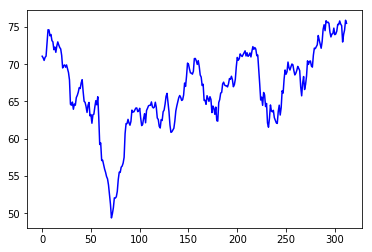

In [14]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [15]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,\
                                   mainQN.state_in:state,mainQN.batch_size:1,\
                                   mainQN.num_quantiles:num_quantile_samples,\
                                   mainQN.quantiles_shape:num_quantile_samples})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading Model...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_REAL_stocks_version\savedModel\IQN_arch0-option_T50-history_t15-softUpdateTrue-tau0.001-huber_lossTrue-freq100-batch64-capacity3000-lambda0.0025-final
episode 100: 	0.02652189766529705	10.58
episode 200: 	0.02766984530800623	12.44
episode 300: 	0.02767885668883937	12.42
episode 400: 	0.02530776842747408	12.44
episode 500: 	0.02524331554113547	12.55
episode 600: 	0.026110141135642483	12.0

episode 14900: 	0.028728780825621705	9.92
episode 15000: 	0.032963508580415295	12.0
#Average reward per episode 15000: 0.0275909261116231
episode 15100: 	0.026588699218444756	11.5
episode 15200: 	0.019695327818818664	12.15
episode 15300: 	0.03030030223671432	9.59
episode 15400: 	0.026507119243535108	12.03
episode 15500: 	0.023657686578481843	9.59
episode 15600: 	0.030780633407989585	11.07
episode 15700: 	0.021431177795661706	11.78
episode 15800: 	0.024651261043231294	11.65
episode 15900: 	0.031103557714817716	10.49
episode 16000: 	0.02425429959282102	13.84
episode 16100: 	0.02596829978241723	11.86
episode 16200: 	0.03128380754110437	12.29
episode 16300: 	0.03736508546295083	14.12
episode 16400: 	0.028250052079301823	10.67
episode 16500: 	0.024819450442610816	10.84
episode 16600: 	0.027820535515439834	11.73
episode 16700: 	0.025354582303223978	12.79
episode 16800: 	0.027948327681297888	10.2
episode 16900: 	0.021188965781537953	10.4
episode 17000: 	0.02322766623754854	9.48
episode 17100:

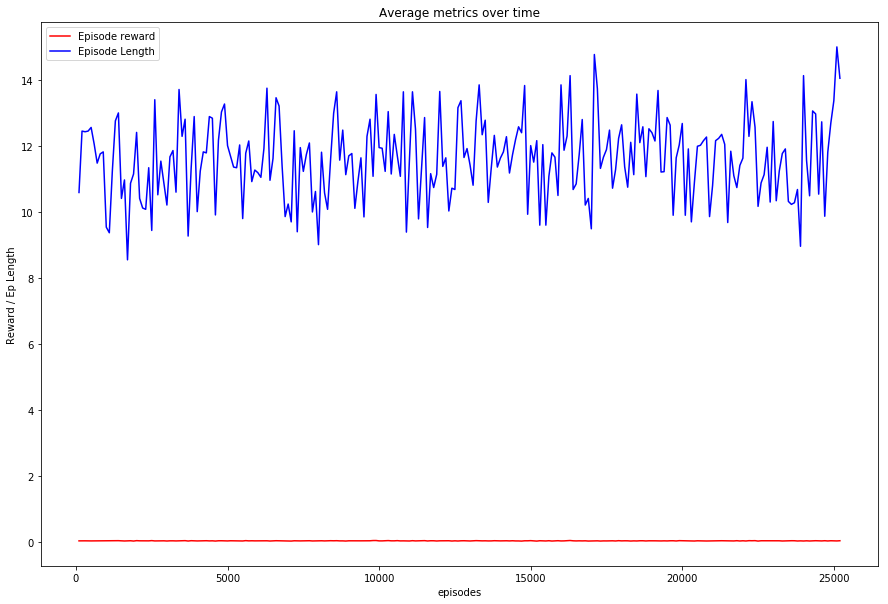

In [17]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

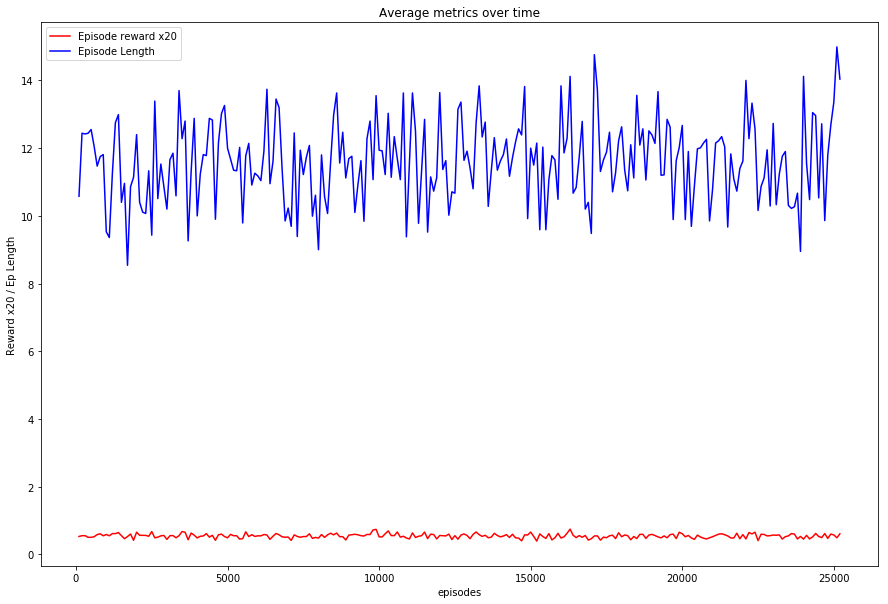

In [18]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

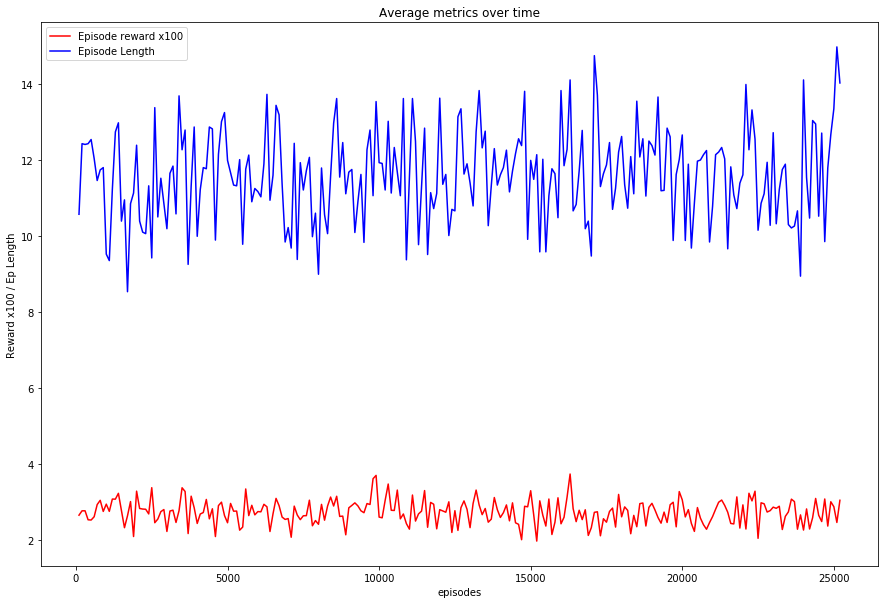

In [19]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

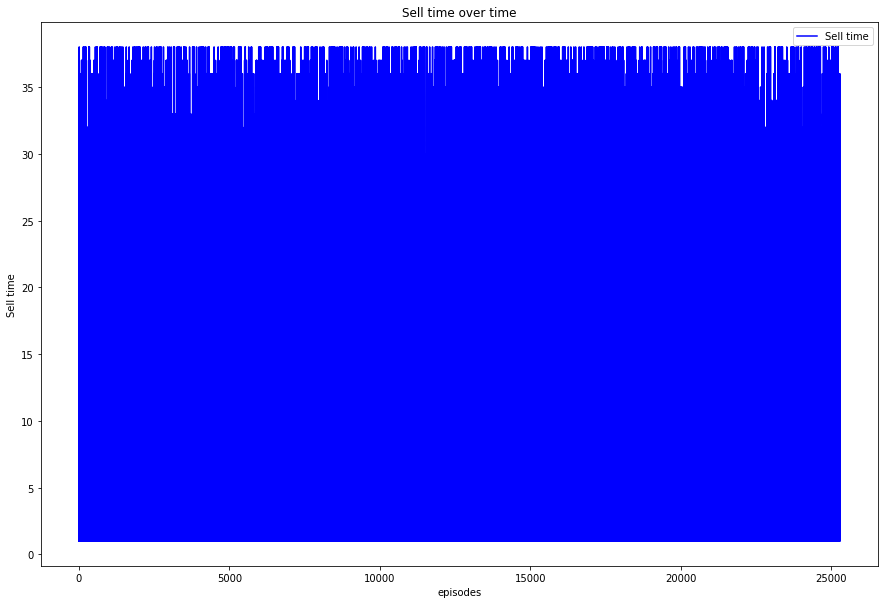

In [20]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Second Valid

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 229
num_episodes_per_epoch: 14689
min value of stock: 65.53499984741211, max value of stock: 80.26499938964844


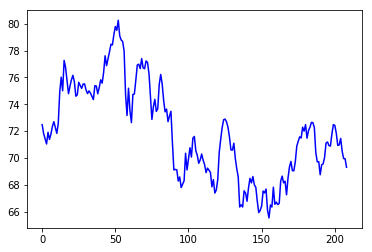

In [21]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

In [22]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,\
                                   mainQN.state_in:state,mainQN.batch_size:1,\
                                   mainQN.num_quantiles:num_quantile_samples,\
                                   mainQN.quantiles_shape:num_quantile_samples})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_REAL_stocks_version\savedModel\IQN_arch0-option_T50-history_t15-softUpdateTrue-tau0.001-huber_lossTrue-freq100-batch64-capacity3000-lambda0.0025-final
episode 100: 	0.028391781333005392	10.95
episode 200: 	0.026547449107236207	12.9
episode 300: 	0.02545282818955867	12.6
episode 400: 	0.025793766655003526	10.63
episode 500: 	0.03348069475712346	13.21
episode 600: 	0.02476895770008615	13.15
episode 700: 	0.026646303717352368	10.48
episode 800: 	0.03374749644397612	13.86
episode 900: 	0.03500419125002012	13.46
episode 1000: 	0.032283865864530546	12.79
episode 1100: 	0.028466436224788484	13.66
episode 1200: 	0.026817592592646558	11.89
episode 1300: 	0.029222605065288385	16.24
episode 1400: 	0.02489074575813064	13.31
episode 1500: 	0.026029830115697393	11.29
episode 1600: 	0.027260846487225585	13.45
episode 1700: 	0.026804195914579748	10.17
episode 1800: 	0.027359219131

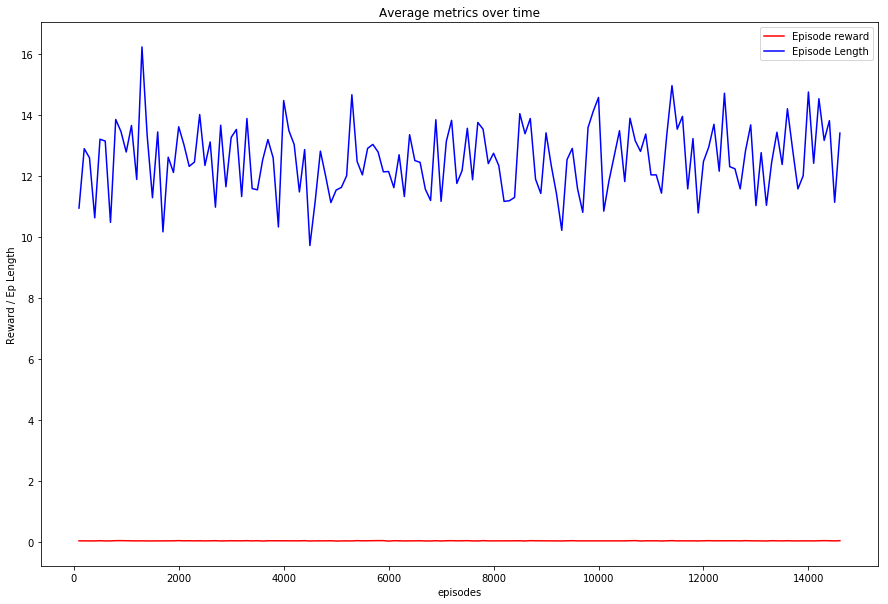

In [24]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

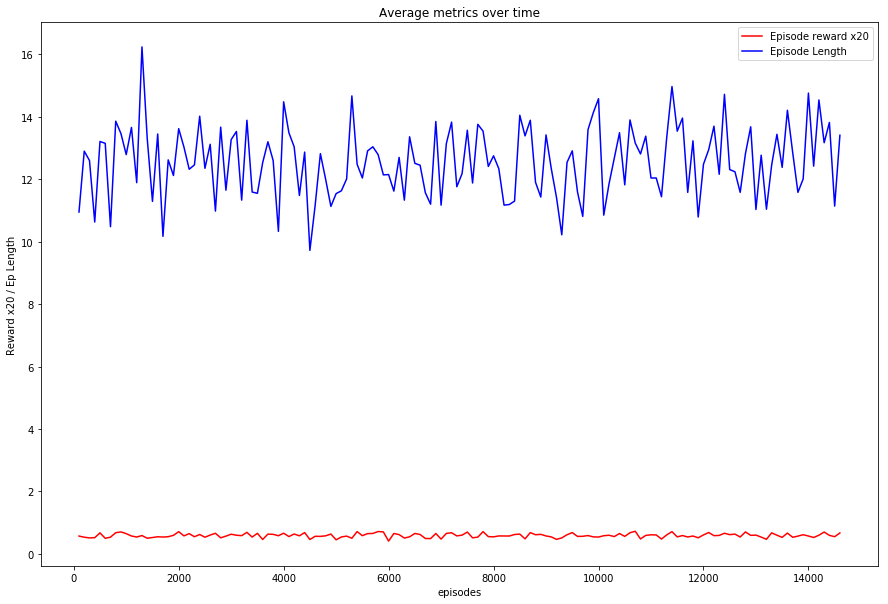

In [25]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

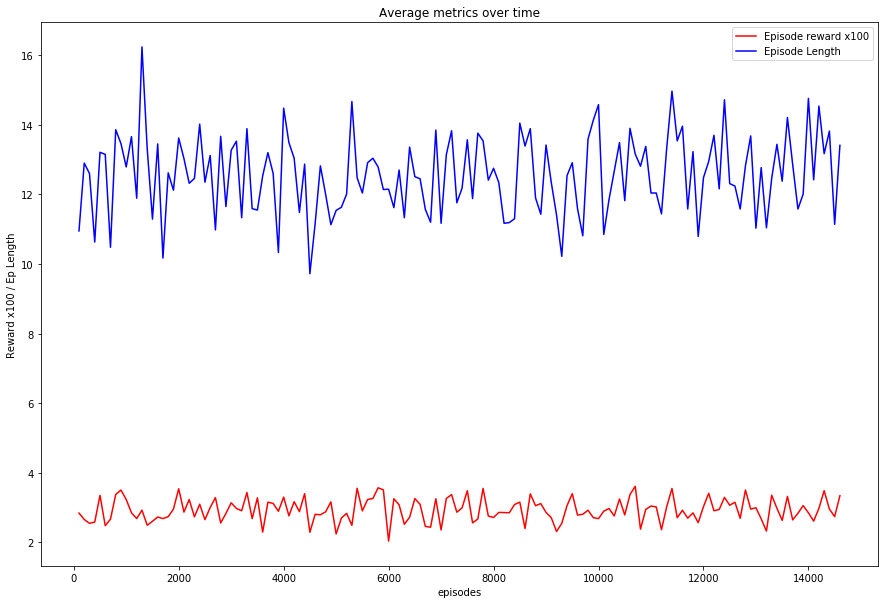

In [26]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

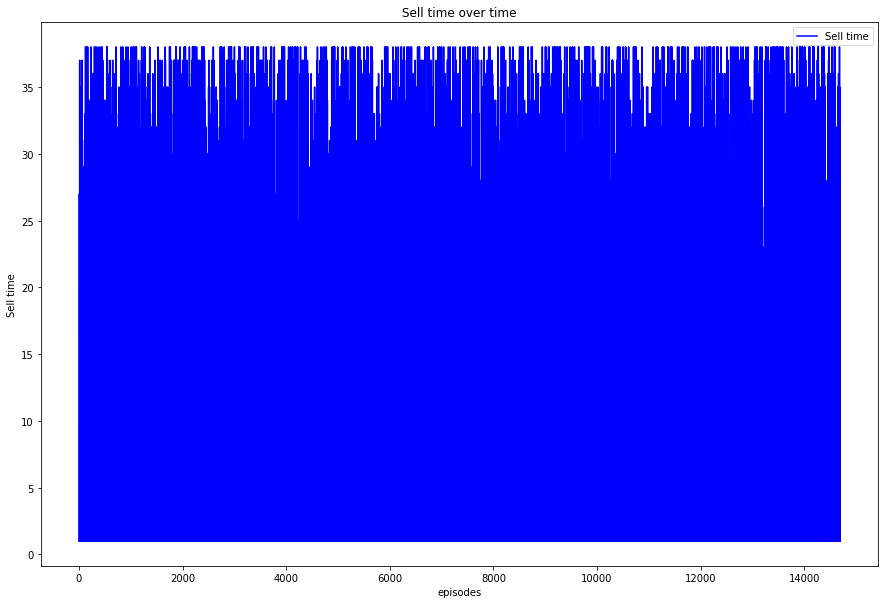

In [27]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Print size of remaining objects

In [28]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
#sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
list_objects = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
#print(list_objects)
for x,y in list_objects:
    print(str(x)+": "+str(y))
    del x

jList: 124920
maxPossibleOptionP_returnList: 124920
maxPossibleOptionR_P_returnList: 124920
maxPossibleP_returnList: 124920
maxPossibleR_P_returnList: 124920
maxPossiblerList: 124920
option_percentage_rList: 124920
option_real_percentage_rList: 124920
percentage_rList: 124920
rList: 124920
real_percentage_rList: 124920
sTimeList: 124920
real_test_data: 2600
test_data: 2600
real_train_data: 1768
train_data: 1768
Qnetwork: 1464
AvgEpisodeList: 1248
AvgrList: 1248
AvgsTimeList: 1248
AmericanOptionPricing: 1056
GBM: 1056
MinMaxScaler: 1056
experience_buffer: 1056
real_stocks_test_data: 912
real_stocks_train_data: 912
stock_names: 912
stocks_test_data: 912
stocks_train_data: 912
stock_names_all: 880
episodeBuffer: 528
stock_names_2: 440
path: 333
final_trained_model_name: 263
trained_model_name: 257
s1P: 232
sP: 232
build_data: 136
leaky_relu: 136
length: 136
normalize_data: 136
prepare_company_stock: 136
prepare_company_stock_yahoo: 136
prepare_data: 136
processState: 136
set_seed: 136
upd